# START

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from scipy.fft import fft, ifft, fftshift, ifftshift
from scipy import signal

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

#simple forecasting
from statsforecast.models import HistoricAverage
from statsforecast.models import Naive
from statsforecast.models import SeasonalNaive
from statsforecast.models import RandomWalkWithDrift

#ARIMA SARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# PROJECT STEPS

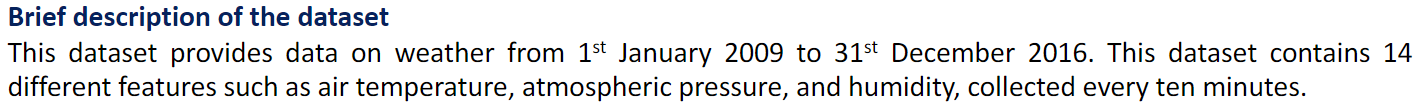

## Box-Jenkins method
When dealing with the family of ARIMA models, it is important to remember the **Box-Jenkins methodology** proposed by George Box and Gwilym Jenkins in their seminal book entitled *Time Series Analysis: Forecasting and Control* (1970) to find the best model. This refers to a systematic method of identifying, fitting, checking, and using ARIMA models built for time series forecasting. The approach starts with the assumption that the process that generated the time series can be approximated using a model from the ARIMA family. Starting from the available time series and use separate train/test sets, the process includes the following steps:

**1.   Model Identification:** as first step, it is important to verify the stationarity, determine if our time series is seasonal and find the seasonal period, and eventually apply appropriate transformations to reduce the variance (e.g., logarithm). When data have a strong seasonal pattern, seasonal differencing should be used as first step. Once stationarity and seasonality have been addressed, the next step is to identify the order (p,d,q) of ARIMA models in order to capture the salient dynamic features
of the data. This is usually done by relying on ACF/PACF plots or on grid search;

**2.   Model estimation:**  Once the model order has been identified, the model parameter are estimated generally using maximum likelihood estimation. Appropriate criteria, such as AIC, AICc and BIC, have to be used to compare and select the best model;

**3.   Model diagnostic:** After fitting the model on the train data, conduct goodness-of-fit checks to ensure the model describes the data adequately. In particular the residuals are taken and it is assessed whether they are white noise and they are normally distributed. ACF plot of the residuals can help in this respect, along with statistical tests as the Ljung-Box test.
If the assumed model is appropriate for the data, the residuals should satisfy these assumptions. If they are not satisfied, we have to go back to the model identification step and try to develop a better model;

**4.   Forecasting:** If the model is good, we can finally perform the forecasting analyses in the separate test set, and perform all the performance evalutations (e.g., MAE, MSE/RMSE, MAPE, R2).


# LOADING CONVERTING AND CLEANING OF THE DATA

## Load

In [2]:
Weather_data = pd.read_csv('Weather_ts.csv', sep=',', parse_dates=['Date Time'], date_format={'Date Time': '%d.%m.%Y %H:%M:%S'}, index_col='Date Time')
#with only the parser the data will not be datatime
#to resolve this problem i use the date_format
display(Weather_data.head(10))

p (mbar)  T (degC)  Tpot (K)  Tdew (degC)  rh (%)  \
Date Time                                                                
2009-01-01 00:10:00    996.52     -8.02    265.40        -8.90    93.3   
2009-01-01 00:20:00    996.57     -8.41    265.01        -9.28    93.4   
2009-01-01 00:30:00    996.53     -8.51    264.91        -9.31    93.9   
2009-01-01 00:40:00    996.51     -8.31    265.12        -9.07    94.2   
2009-01-01 00:50:00    996.51     -8.27    265.15        -9.04    94.1   
2009-01-01 01:00:00    996.50     -8.05    265.38        -8.78    94.4   
2009-01-01 01:10:00    996.50     -7.62    265.81        -8.30    94.8   
2009-01-01 01:20:00    996.50     -7.62    265.81        -8.36    94.4   
2009-01-01 01:30:00    996.50     -7.91    265.52        -8.73    93.8   
2009-01-01 01:40:00    996.53     -8.43    264.99        -9.34    93.1   

                     VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                                  
2009-01-01 00:10:00          3.33          3.11          0.22       1.94   
2009-01-01 00:20:00          3.23          3.02          0.21       1.89   
2009-01-01 00:30:00          3.21          3.01          0.20       1.88   
2009-01-01 00:40:00          3.26          3.07          0.19       1.92   
2009-01-01 00:50:00          3.27          3.08          0.19       1.92   
2009-01-01 01:00:00          3.33          3.14          0.19       1.96   
2009-01-01 01:10:00          3.44          3.26          0.18       2.04   
2009-01-01 01:20:00          3.44          3.25          0.19       2.03   
2009-01-01 01:30:00          3.36          3.15          0.21       1.97   
2009-01-01 01:40:00          3.23          3.00          0.22       1.88   

                     H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)  \
Date Time                                                                     
2009-01-01 00:10:00             3.12       1307.75      1.03           1.75   
2009-01-01 00:20:00             3.03       1309.80      0.72           1.50   
2009-01-01 00:30:00             3.02       1310.24      0.19           0.63   
2009-01-01 00:40:00             3.08       1309.19      0.34           0.50   
2009-01-01 00:50:00             3.09       1309.00      0.32           0.63   
2009-01-01 01:00:00             3.15       1307.86      0.21           0.63   
2009-01-01 01:10:00             3.27       1305.68      0.18           0.63   
2009-01-01 01:20:00             3.26       1305.69      0.19           0.50   
2009-01-01 01:30:00             3.16       1307.17      0.28           0.75   
2009-01-01 01:40:00             3.02       1309.85      0.59           0.88   

                     wd (deg)  
Date Time                      
2009-01-01 00:10:00     152.3  
2009-01-01 00:20:00     136.1  
2009-01-01 00:30:00     171.6  
2009-01-01 00:40:00     198.0  
2009-01-01 00:50:00     214.3  
2009-01-01 01:00:00     192.7  
2009-01-01 01:10:00     166.5  
2009-01-01 01:20:00     118.6  
2009-01-01 01:30:00     188.5  
2009-01-01 01:40:00     185.0

Variables 

-   1	Date Time		Date-time reference (INDEX)
-   2	p (mbar)		Pressure used to quantify internal pressure (in millibars) 
-   3	T (degC)		Temperature in Celsius
-   4	Tpot (K)	             Temperature in Kelvin
-   5	Tdew (degC)		Temperature in Celsius relative to humidity 
-   6	rh (%)		             Relative Humidity 
-   7	VPmax (mbar)	Saturation vapor pressure
-   8	VPact (mbar)		Vapor pressure
-   9	VPdef (mbar)		Vapor pressure deficit
-   10	sh (g/kg)		Specific humidity
-   11	H2OC (mmol/mol)	Water vapor concentration
-   12	rho (g/m**3)	             Airtight 
-   13	wv (m/s)		Wind speed
-   14	max. wv (m/s)	Maximum wind speed
-   15	wd (deg)		Wind direction in degrees


## Clean

In [3]:
#info
Weather_data.info() #no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420550 entries, 2009-01-01 00:10:00 to 2016-12-31 23:50:00
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   p (mbar)         420550 non-null  float64
 1   T (degC)         420550 non-null  float64
 2   Tpot (K)         420550 non-null  float64
 3   Tdew (degC)      420550 non-null  float64
 4   rh (%)           420550 non-null  float64
 5   VPmax (mbar)     420550 non-null  float64
 6   VPact (mbar)     420550 non-null  float64
 7   VPdef (mbar)     420550 non-null  float64
 8   sh (g/kg)        420550 non-null  float64
 9   H2OC (mmol/mol)  420550 non-null  float64
 10  rho (g/m**3)     420550 non-null  float64
 11  wv (m/s)         420550 non-null  float64
 12  max. wv (m/s)    420550 non-null  float64
 13  wd (deg)         420550 non-null  float64
dtypes: float64(14)
memory usage: 48.1 MB


In [4]:
#second test null value
Weather_data.isna().sum() #no null values

p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

There are no null value, the dataset is alredy clean

In [5]:
#columns
Weather_data.columns

Index(['p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)', 'rh (%)',
       'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')

In [6]:
Weather_data.describe()

p (mbar)       T (degC)       Tpot (K)    Tdew (degC)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean      989.212751       9.450181     283.492779       4.955886   
std         8.358475       8.423346       8.504449       6.730651   
min       913.600000     -23.010000     250.600000     -25.010000   
25%       984.200000       3.360000     277.430000       0.240000   
50%       989.580000       9.420000     283.470000       5.220000   
75%       994.720000      15.470000     289.530000      10.070000   
max      1015.350000      37.280000     311.340000      23.110000   

              rh (%)   VPmax (mbar)   VPact (mbar)   VPdef (mbar)  \
count  420550.000000  420550.000000  420550.000000  420550.000000   
mean       76.008260      13.576273       9.533771       4.042419   
std        16.476195       7.739016       4.184158       4.896855   
min        12.950000       0.950000       0.790000       0.000000   
25%        65.210000       7.780000       6.210000       0.870000   
50%        79.300000      11.820000       8.860000       2.190000   
75%        89.400000      17.600000      12.350000       5.300000   
max       100.000000      63.770000      28.320000      46.010000   

           sh (g/kg)  H2OC (mmol/mol)   rho (g/m**3)       wv (m/s)  \
count  420550.000000    420550.000000  420550.000000  420550.000000   
mean        6.022418         9.640238    1216.062557       1.702225   
std         2.656135         4.235388      39.975064      65.446792   
min         0.500000         0.800000    1059.450000   -9999.000000   
25%         3.920000         6.290000    1187.490000       0.990000   
50%         5.590000         8.960000    1213.790000       1.760000   
75%         7.800000        12.490000    1242.770000       2.860000   
max        18.130000        28.820000    1393.540000      28.490000   

       max. wv (m/s)       wd (deg)  
count  420550.000000  420550.000000  
mean        3.056558     174.743714  
std        69.017014      86.681794  
min     -9999.000000       0.000000  
25%         1.760000     124.900000  
50%         2.960000     198.100000  
75%         4.740000     234.100000  
max        23.500000     360.000000

General information:
T (decC): (Temperaure in Celsius)
-   general tempretaure (mean) = 9.45
-   Lowest recorded temperature = -23 -> i think that can be an outlier (check becouse i don't know where the data was collected)
-   highest recorded temperature = 37 -> (check outliers)
-   the general variabilit in the temperature = 8.5

wv (m/s): (Wind speed)
-   the min velocity = -9999.00 (outlier, should be removed)

max. wv(m/s): (Max Wind speed)
-   the min velocity = -9999.00 (outlier, should be removed)

## Convert

we want to have weekly frequency

In [7]:
Weather_data.index

DatetimeIndex(['2009-01-01 00:10:00', '2009-01-01 00:20:00',
               '2009-01-01 00:30:00', '2009-01-01 00:40:00',
               '2009-01-01 00:50:00', '2009-01-01 01:00:00',
               '2009-01-01 01:10:00', '2009-01-01 01:20:00',
               '2009-01-01 01:30:00', '2009-01-01 01:40:00',
               ...
               '2016-12-31 22:20:00', '2016-12-31 22:30:00',
               '2016-12-31 22:40:00', '2016-12-31 22:50:00',
               '2016-12-31 23:00:00', '2016-12-31 23:10:00',
               '2016-12-31 23:20:00', '2016-12-31 23:30:00',
               '2016-12-31 23:40:00', '2016-12-31 23:50:00'],
              dtype='datetime64[ns]', name='Date Time', length=420550, freq=None)

In [8]:
Weather_data.index.year.unique()

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], dtype='int32', name='Date Time')

In [9]:
Weather_data.index.month.unique()

Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int32', name='Date Time')

In [10]:
Weather_data.index.day.unique()

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
      dtype='int32', name='Date Time')

In [11]:
Weather_data.index.minute.unique()

Index([10, 20, 30, 40, 50, 0], dtype='int32', name='Date Time')

In [12]:
Weather_data.index.second.unique()

Index([0], dtype='int32', name='Date Time')

In [13]:
#convert the data time in weekly frequency
Weather_data_wk = Weather_data.resample('W').mean()
display(Weather_data_wk)

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                                
2009-01-04   996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11   999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18   991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25   970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01   990.295337  -2.464573  271.454127    -3.848323  90.406944   
...                 ...        ...         ...          ...        ...   
2016-12-04   999.956121  -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891   1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288   2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817   1.969593  275.060228    -0.343909  85.042927   
2017-01-01  1007.889549   2.689560  275.233866    -0.238472  81.632986   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   
...                  ...           ...           ...        ...   
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   
2017-01-01      7.702361      6.203750      1.498484   3.838715   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-11         2.372718   1327.335734  1.312153       2.256984  158.967391  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-01-25         5.613720   1230.040417  2.553998       3.973105  188.601022  
2009-02-01         4.663750   1272.179296  1.981885       3.170645   46.615129  
...                     ...           ...       ...            ...         ...  
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  
2017-01-01         6.156250   1270.206458  1.972280       3.632130  222.820949  

[418 rows x 14 columns]

## Divide dataset into training and testing

The main aim of this project is to perform weather forecasting for the period January-December 2016.

In [14]:
#train everything before january 2016
Weather_data_wk_train = Weather_data_wk[Weather_data_wk.index < '2016-01-01']
Weather_data_wk_test = Weather_data_wk[Weather_data_wk.index >= '2016-01-01']

display(Weather_data_wk_train.index.year.unique())
display(Weather_data_wk_test.index.year.unique())

Index([2009, 2010, 2011, 2012, 2013, 2014, 2015], dtype='int32', name='Date Time')

Index([2016, 2017], dtype='int32', name='Date Time')

# EXPLORING THE DATASET

## Descriptive Statistic

### Describe

In [15]:
Weather_data_wk.describe()

p (mbar)    T (degC)    Tpot (K)  Tdew (degC)      rh (%)  \
count   418.000000  418.000000  418.000000   418.000000  418.000000   
mean    989.238368    9.428490  283.468976     4.943220   76.047001   
std       6.217979    7.431565    7.454327     6.135823    8.981430   
min     967.816796  -12.640000  259.938155   -15.437232   54.132083   
25%     985.893214    3.707639  277.995749     0.534705   69.596037   
50%     989.290461    9.483542  283.648353     5.367331   76.297877   
75%     992.865556   15.301004  289.378093    10.106562   83.067956   
max    1007.889549   24.770526  298.443155    16.751081   95.171131   

       VPmax (mbar)  VPact (mbar)  VPdef (mbar)   sh (g/kg)  H2OC (mmol/mol)  \
count    418.000000    418.000000    418.000000  418.000000       418.000000   
mean      13.557678      9.526417      4.031179    6.017641         9.632617   
std        6.400325      3.770776      3.033723    2.389490         3.811023   
min        2.419841      1.911012      0.202073    1.180605         1.896250   
25%        8.117391      6.436109      1.544459    4.040732         6.480258   
50%       12.371086      9.073214      3.243462    5.703398         9.136746   
75%       17.964365     12.528566      5.945732    7.911840        12.657299   
max       33.085079     19.144921     16.535179   12.155169        19.398016   

       rho (g/m**3)    wv (m/s)  max. wv (m/s)    wd (deg)  
count    418.000000  418.000000     418.000000  418.000000  
mean    1216.192035    1.701207       3.054848  174.800532  
std       34.602324    8.760265       9.746778   35.462175  
min     1151.149742 -176.614435    -194.960387   46.615129  
25%     1188.048755    1.734730       2.908113  153.013038  
50%     1212.522202    2.021007       3.398120  182.851230  
75%     1239.563063    2.411503       4.009271  201.698418  
max     1347.082302    4.619732       7.043562  240.663601

In [16]:
display(Weather_data_wk)

p (mbar)   T (degC)    Tpot (K)  Tdew (degC)     rh (%)  \
Date Time                                                                
2009-01-04   996.446696  -4.292070  269.146087    -6.185148  87.255409   
2009-01-11   999.146161 -11.057847  262.168393   -13.171438  84.714841   
2009-01-18   991.308760  -1.717867  272.126657    -4.664692  81.310595   
2009-01-25   970.486319   1.151438  276.681220    -1.678264  82.035218   
2009-02-01   990.295337  -2.464573  271.454127    -3.848323  90.406944   
...                 ...        ...         ...          ...        ...   
2016-12-04   999.956121  -0.467679  272.701944    -3.387222  81.552579   
2016-12-11  1000.134891   1.667212  274.823413    -1.334246  81.225665   
2016-12-18  1002.300288   2.645923  275.628373     1.012192  89.163800   
2016-12-25  1000.907817   1.969593  275.060228    -0.343909  85.042927   
2017-01-01  1007.889549   2.689560  275.233866    -0.238472  81.632986   

            VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh (g/kg)  \
Date Time                                                         
2009-01-04      4.511496      3.918348      0.593009   2.451287   
2009-01-11      2.831081      2.369058      0.462044   1.477421   
2009-01-18      5.561796      4.483313      1.078720   2.820536   
2009-01-25      6.752004      5.444335      1.307619   3.499306   
2009-02-01      5.104276      4.617619      0.486429   2.905952   
...                  ...           ...           ...        ...   
2016-12-04      6.156409      4.900109      1.256071   3.058046   
2016-12-11      7.381587      5.828373      1.553492   3.637927   
2016-12-18      7.507450      6.704841      0.802490   4.174643   
2016-12-25      7.248353      6.080327      1.168135   3.788710   
2017-01-01      7.702361      6.203750      1.498484   3.838715   

            H2OC (mmol/mol)  rho (g/m**3)  wv (m/s)  max. wv (m/s)    wd (deg)  
Date Time                                                                       
2009-01-04         3.934887   1289.293165  1.293252       2.310504  177.589652  
2009-01-11         2.372718   1327.335734  1.312153       2.256984  158.967391  
2009-01-18         4.526012   1270.352133  1.879524       2.970417  178.882599  
2009-01-25         5.613720   1230.040417  2.553998       3.973105  188.601022  
2009-02-01         4.663750   1272.179296  1.981885       3.170645   46.615129  
...                     ...           ...       ...            ...         ...  
2016-12-04         4.906677   1275.453720  1.437123       2.741706  190.730853  
2016-12-11         5.834554   1265.589107  1.437609       2.601359  182.925089  
2016-12-18         6.694365   1262.940823  1.418085       2.399752  185.361032  
2016-12-25         6.076379   1264.651042  1.912788       3.262143  184.388889  
2017-01-01         6.156250   1270.206458  1.972280       3.632130  222.820949  

[418 rows x 14 columns]

### Plot

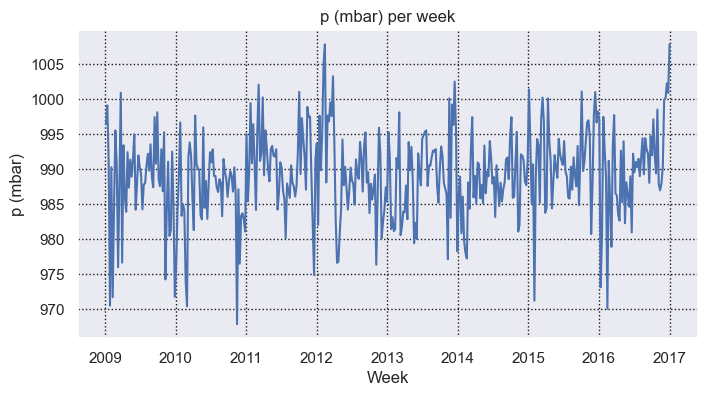

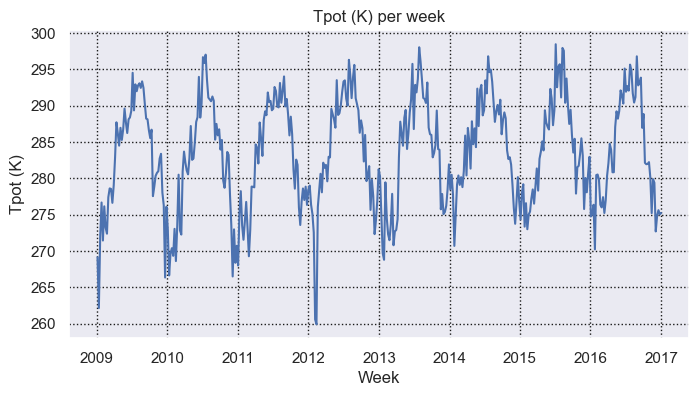

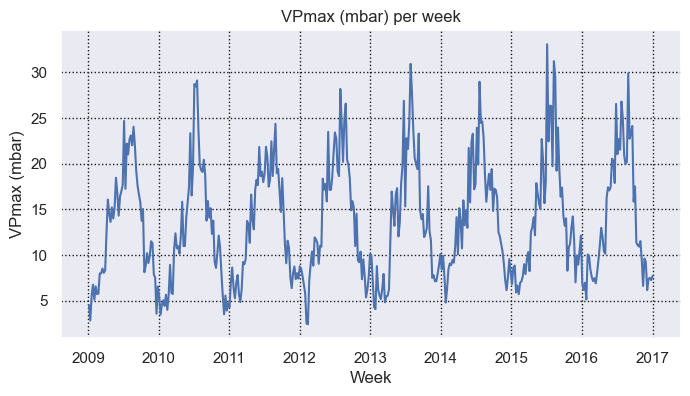

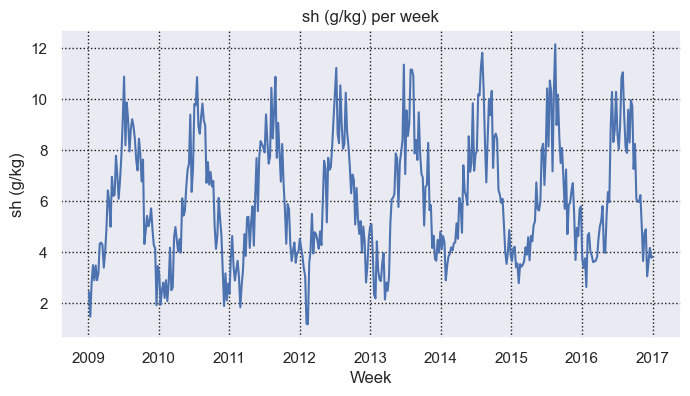

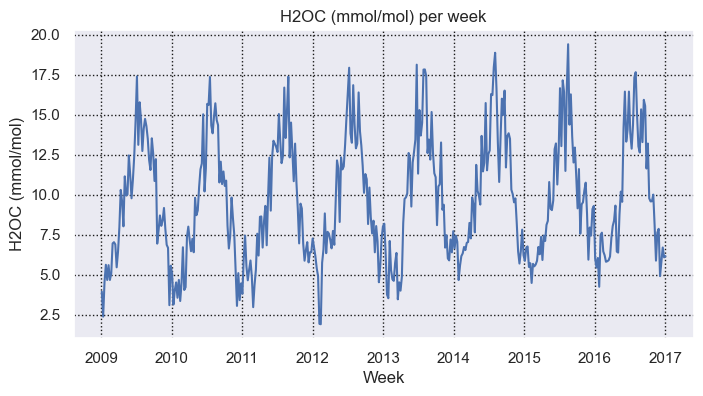

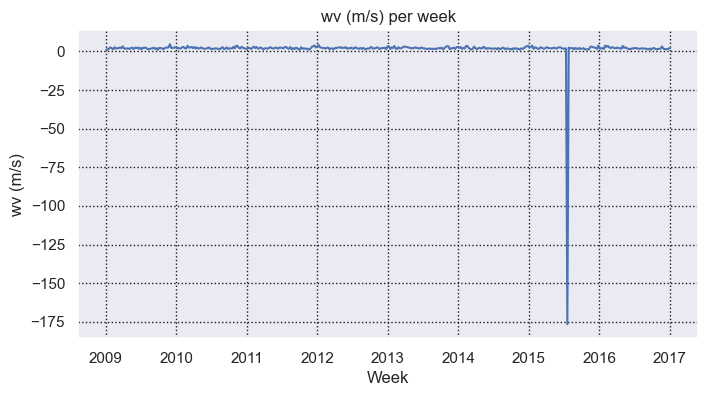

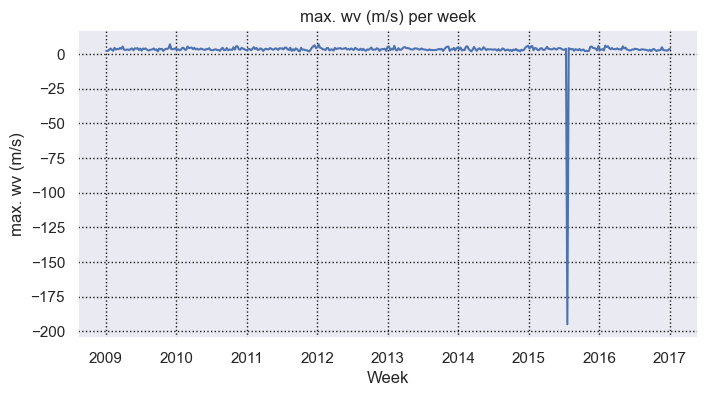

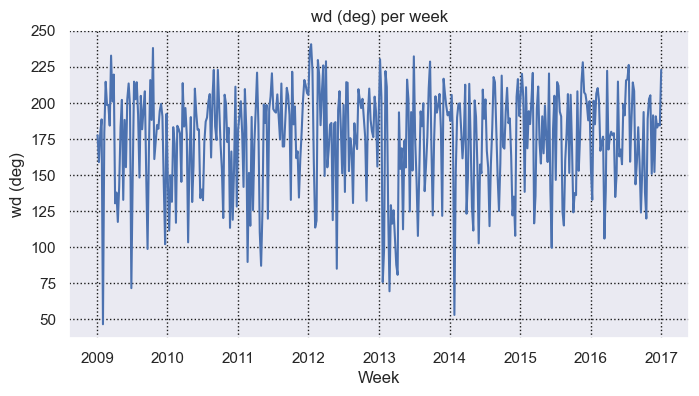

In [17]:
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plt.plot(Weather_data_wk[column])
    plt.grid(True, color = 'k', linestyle = ':')
    plt.title(column + ' per week')
    plt.xlabel('Week')
    plt.ylabel(column)

For most of the time series, there is a clear seasonality, likely on a yearly basis.  

There might be a slight trend in some time series → this needs to be examined further with decomposition and stationarity tests.  

Note for wv, there is a noticeable outlier.

### Histogram

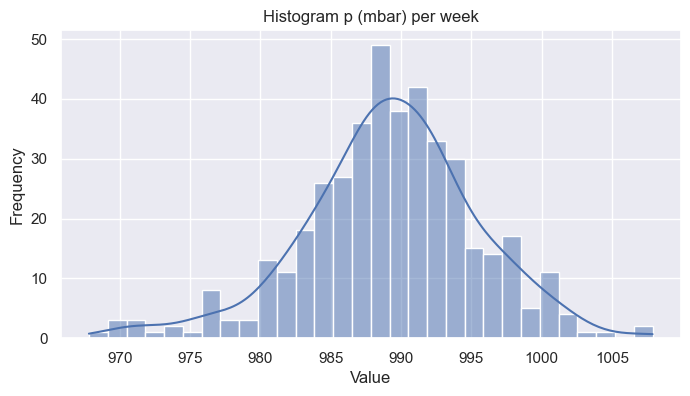

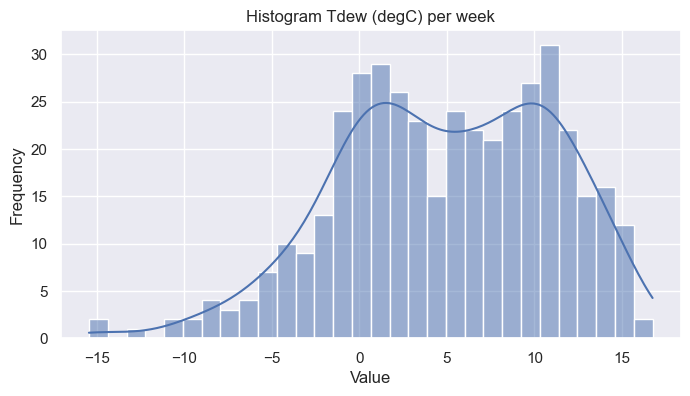

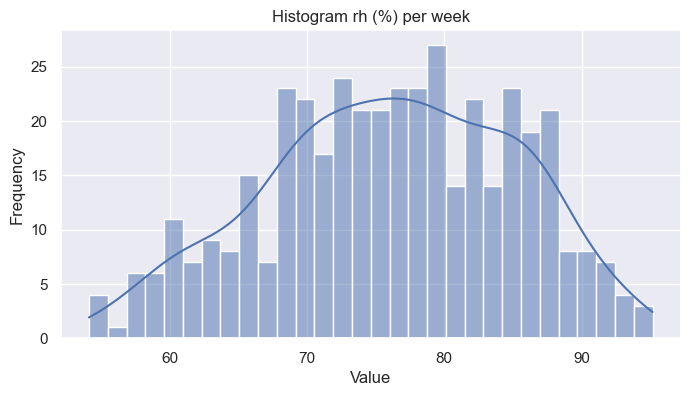

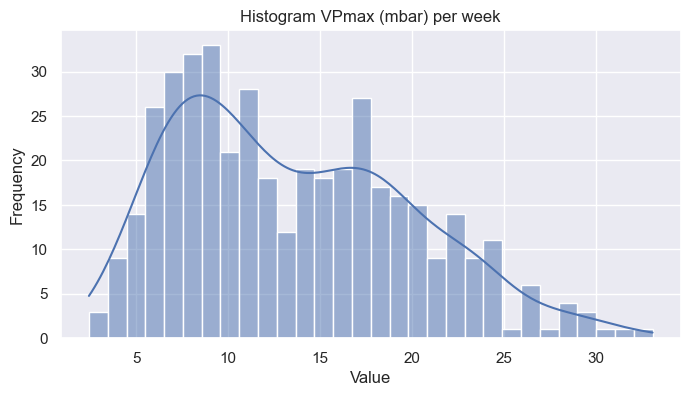

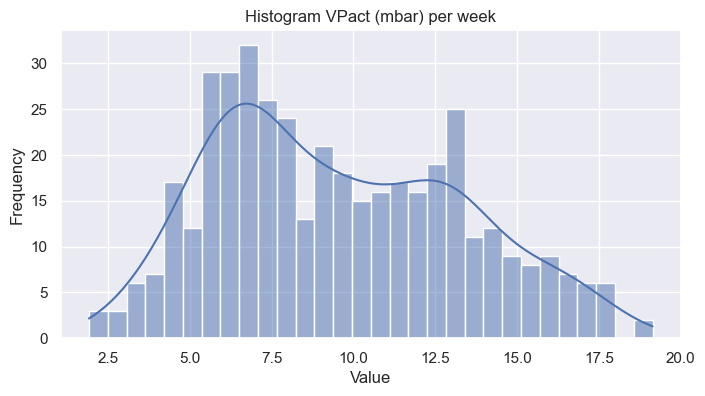

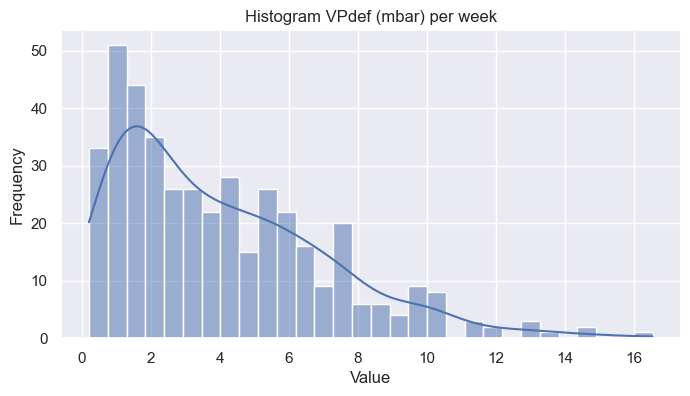

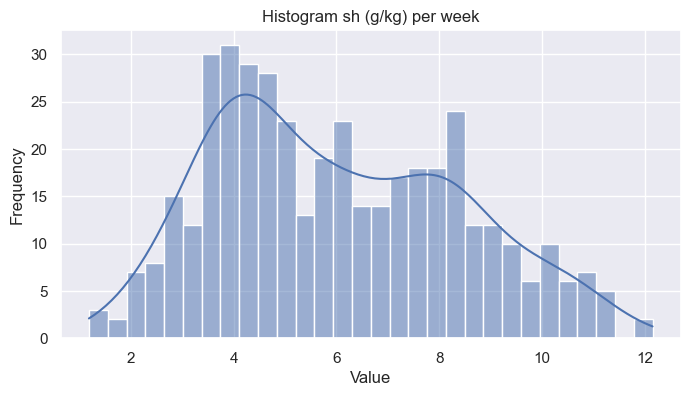

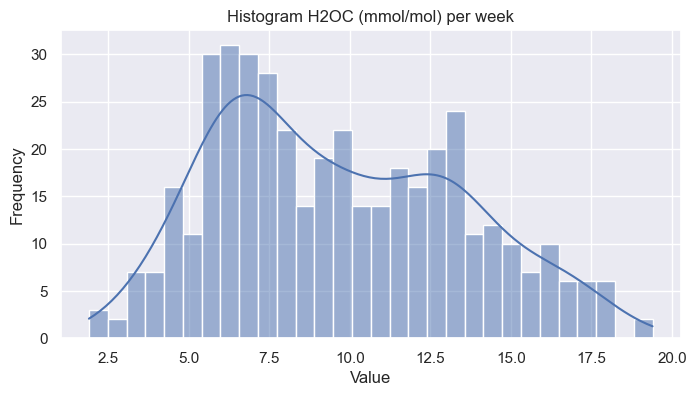

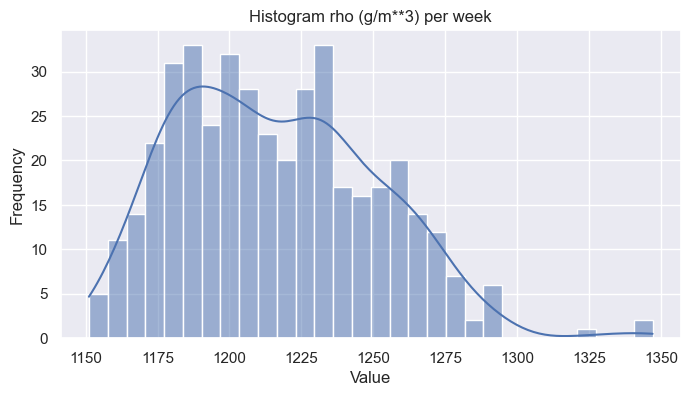

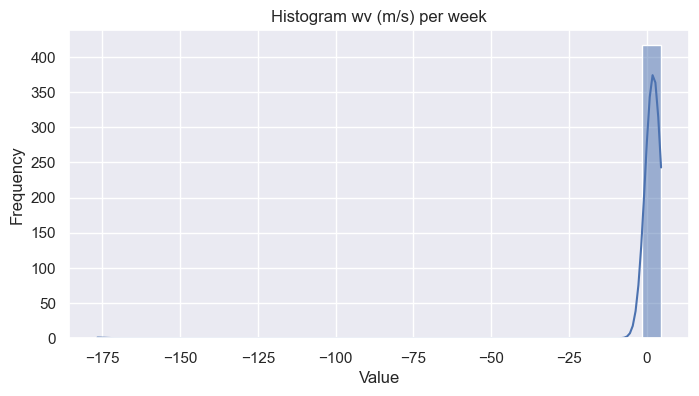

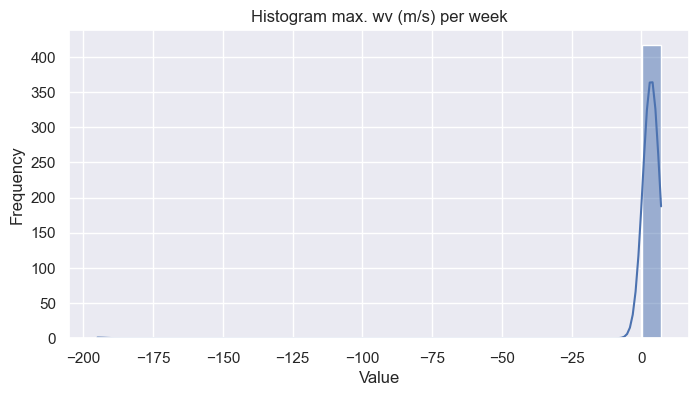

In [35]:
#Histogram
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plt.title('Histogram ' + column + ' per week')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    sns.histplot(Weather_data_wk[column], bins=30, kde=True)
    plt.show()

### Boxplot

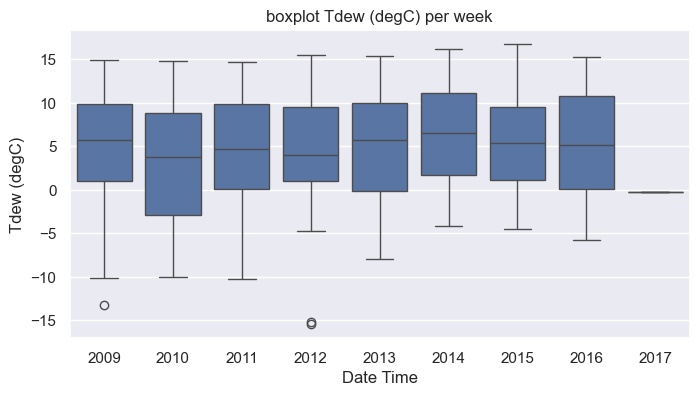

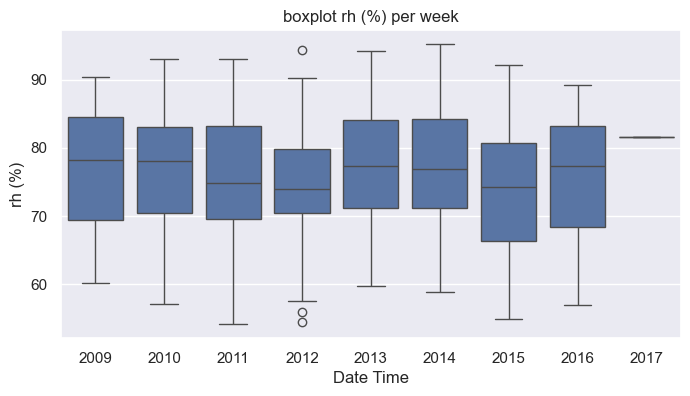

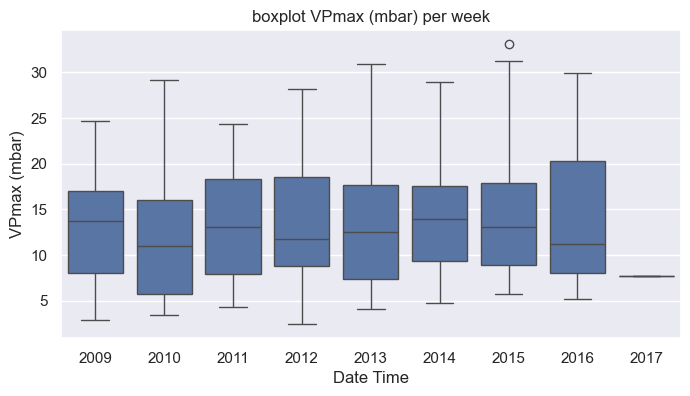

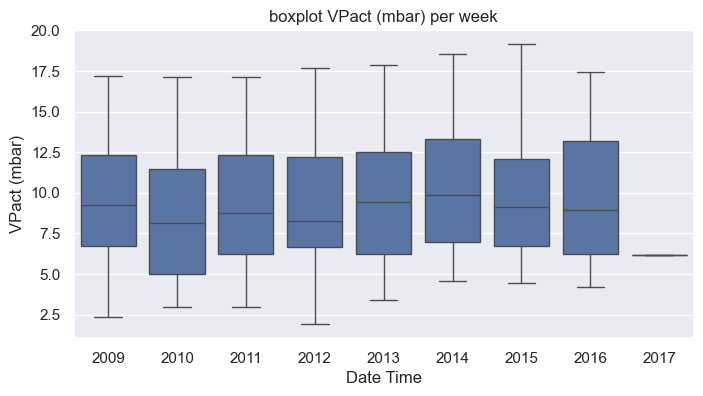

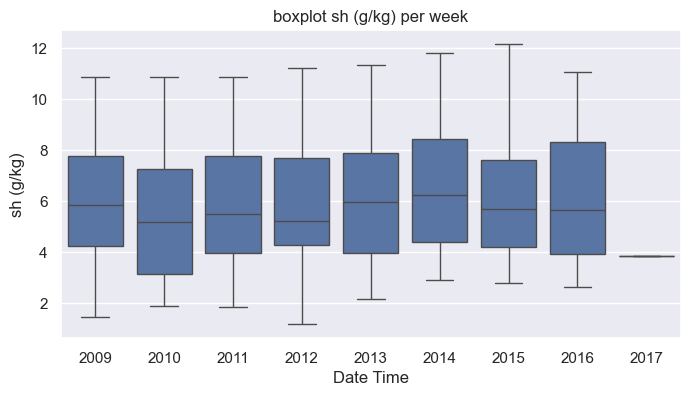

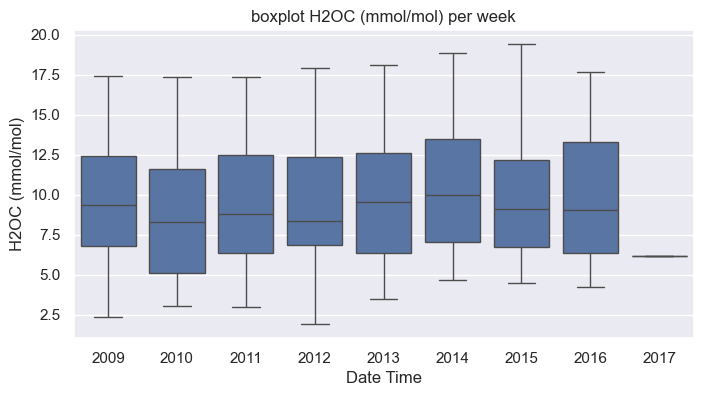

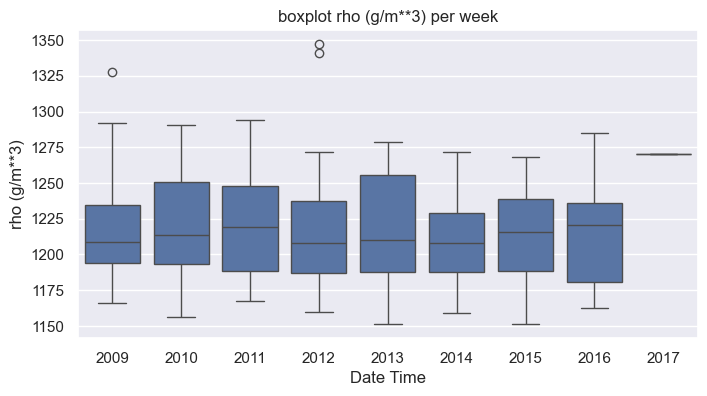

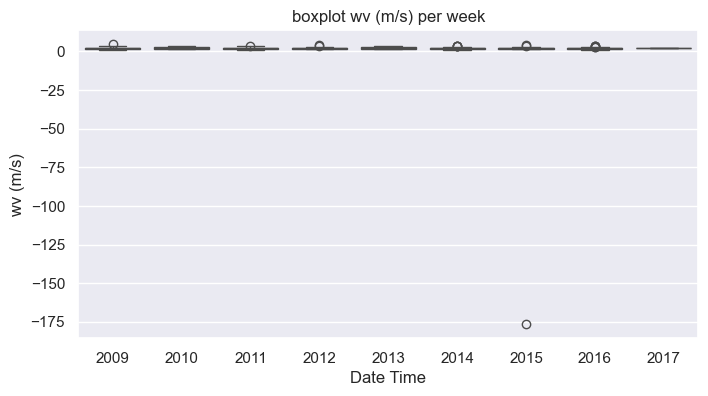

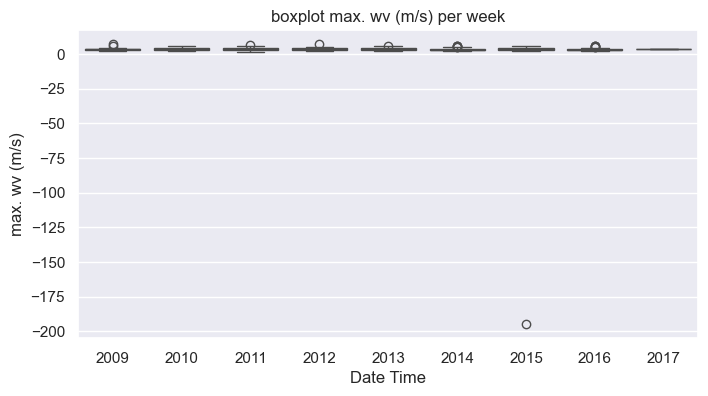

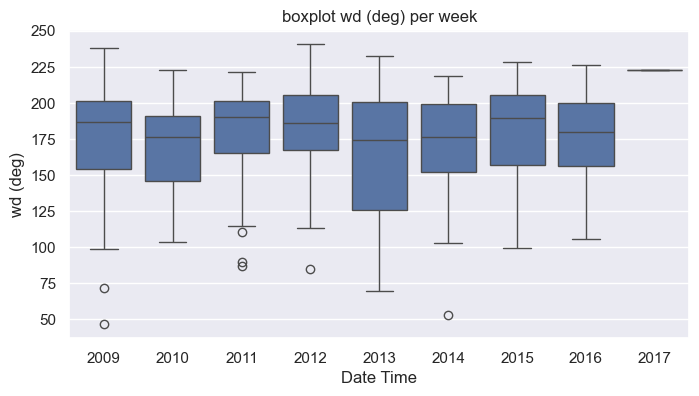

In [19]:
#Boxplot
# plot all the data
for column in Weather_data_wk.columns:
    plt.figure(figsize=(8,4))
    plt.title('boxplot ' + column + ' per week')
    sns.boxplot(x = Weather_data_wk.index.year, y = Weather_data_wk[column])
    plt.show()

From the boxplots, we can observe the presence of outliers in the respective years for the variables considered.  

The only noticeable outlier is in wv.

### Outliers

I decided to use the standard deviation method

In [20]:
for column in Weather_data_wk.columns:
    print('---------------------------')
    print(f'Outlier with standard deviation method for {column}')
    mean_value = np.mean(Weather_data_wk[column]) #calcolo la media
    sd_value = np.std(Weather_data_wk[column]) #calcolo lo sd
    thr = 3*sd_value 
    Lower = mean_value - thr
    Upper = mean_value + thr

    outliers = [i for i in Weather_data_wk[column] if i < Lower or i > Upper] #prendo tutti i valori fuori dal limite -> outlier
    print('Number of outliers:', len(outliers))
    print('Outliers:', outliers)

    P_no_outliers = [i for i in Weather_data_wk[column] if i > Lower and i < Upper]
    print('Number of non-outliers:', len(P_no_outliers))

---------------------------
Outlier with standard deviation method for p (mbar)
Number of outliers: 5
Outliers: [970.4863194444445, 970.3948611111111, 967.8167956349206, 970.0243253968254, 1007.8895486111111]
Number of non-outliers: 413
---------------------------
Outlier with standard deviation method for T (degC)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for Tpot (K)
Number of outliers: 2
Outliers: [260.60050595238096, 259.93815476190474]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for Tdew (degC)
Number of outliers: 2
Outliers: [-15.153799603174603, -15.437232142857143]
Number of non-outliers: 416
---------------------------
Outlier with standard deviation method for rh (%)
Number of outliers: 0
Outliers: []
Number of non-outliers: 418
---------------------------
Outlier with standard deviation method for VPmax (mbar)
Number of outliers: 1
Outlie

As we can see, we found outliers in *wm* and *max wm*.  

Regarding the temperature in Temperature in °C, we did not find any outliers.

### Correlation

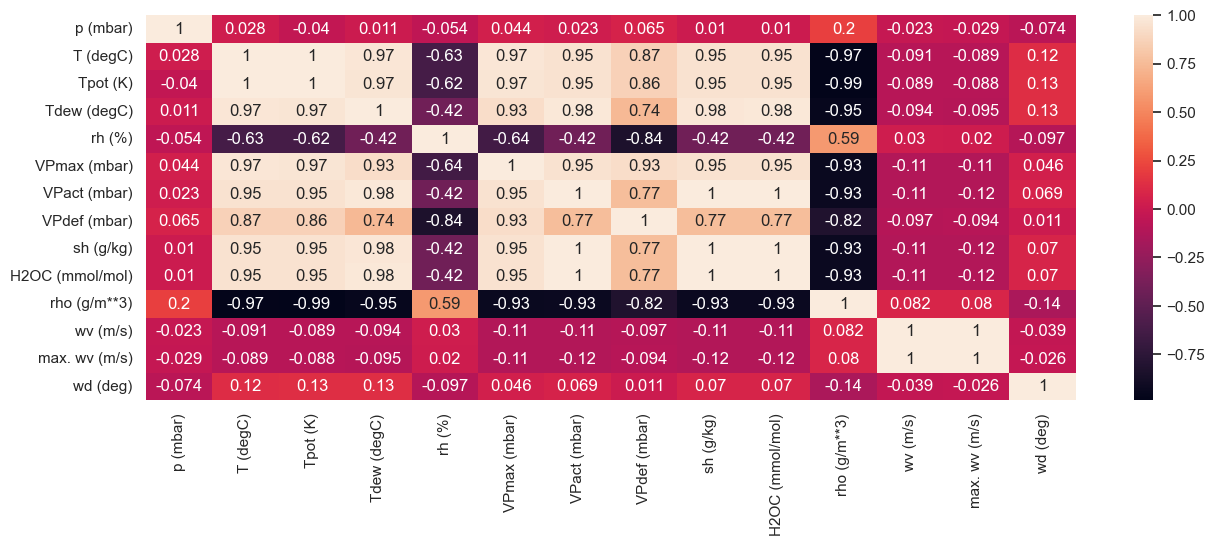

In [21]:
plt.figure(figsize=(15,5))
sns.heatmap(Weather_data_wk.corr(), annot=True)
plt.show()

important correlations to create exogenous variables for T (degC):
-   VPmax (mbar) = Saturation vapor pressure
-   VPact (mbar) = Vapor pressure
-   sh (g/kg) = Specific humidity
-   H2OC (mmol/mol) = Water vapor concentration
-   rho (g/m**3) = Airtight

in general there is a high correlation between the variables

## Frequency Analysis

Frequency analysis shows how the signal energy is distributed over a range of frequencies.

The Fourier Transform can be used for evaluating the frequency content of each signal and the caracteristics of each wave. It decomposes any signal into a sum of multiple sine/cosine signals of different frequencies.


vedere la lezione 6 fatta dalla prof

solo sulla temperatura

### FFT (Fast Fourier Tranformation) and Amplitude Spectrum

In [22]:
'''# FFT and Amplitude Spectrum
for column in Weather_data_wk_train.columns:
    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month
    X = fft(Weather_data_wk_train[column].values)
    N = len(X)
    freq_step = Fs/N
    freq_vec = np.arange(0,Fs,freq_step)

    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
    freq_vec = freq_vec[1:]
    plt.plot(freq_vec,ampl)
    plt.title(f'Double Sided FFT for {column}')
    plt.xlabel('Frequency')
    plt.ylabel('FFT Amplitude |X(freq)|')
    plt.show()'''

'# FFT and Amplitude Spectrum\nfor column in Weather_data_wk_train.columns:\n    Fs = 1 # sampling rate, our unit of measure is "months" (Important!) --> the data are sampled monthly, thus the sampling rate is 1 sample per month\n    X = fft(Weather_data_wk_train[column].values)\n    N = len(X)\n    freq_step = Fs/N\n    freq_vec = np.arange(0,Fs,freq_step)\n\n    ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC\n    freq_vec = freq_vec[1:]\n    plt.plot(freq_vec,ampl)\n    plt.title(f\'Double Sided FFT for {column}\')\n    plt.xlabel(\'Frequency\')\n    plt.ylabel(\'FFT Amplitude |X(freq)|\')\n    plt.show()'

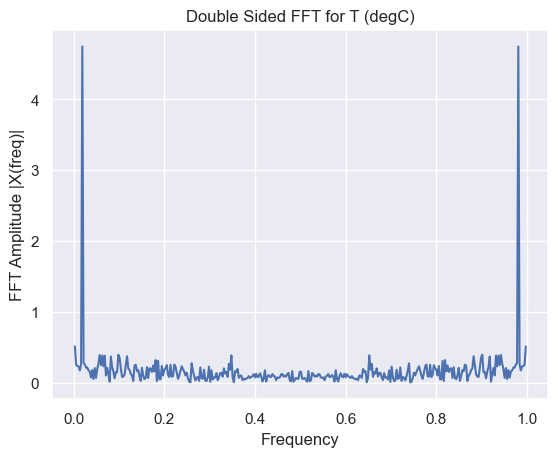

In [ ]:
Fs = 1 #non credo sia corretto 1, capire
X = fft(Weather_data_wk_train['T (degC)'].values)
N = len(X)
freq_step = Fs/N
freq_vec = np.arange(0,Fs,freq_step)

ampl = np.abs(X[1:])/N # Start from 1 to remove the zero frequency component, called DC
freq_vec = freq_vec[1:]
plt.plot(freq_vec,ampl)
plt.title(f'Double Sided FFT for T (degC)')
plt.xlabel('Frequency')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.show()

### Power Spectral Density (PSD) based on Periodgram

PSD plots the power of each frequency component on the y-axis and the frequency on the x-axis. The power can be plotted in linear scale or in log scale. There are different ways to compute the PSD.

In this case i will use Periodogram. It represents the Fourier transform of the autocorrelation of the windowed data sequence.

#### test 1

In [24]:
'''#create a dizio to save the period
dizio_period = {}

for column in Weather_data_wk.columns:
    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]

    #Find the peaks of the periodogram.
    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
    peak_freq = f_per[peaks]
    peak_dens = Pxx_per[peaks]

    #Plot of the analysis transformation and of its peaks. Only the first five are interestings
    fig = plt.figure(figsize=(16,6))
    plt.plot(peak_freq, peak_dens, 'ro')
    plt.plot(f_per[2:],Pxx_per[2:])
    plt.xlabel('Frequency')
    plt.ylabel('Density')
    plt.title(f'PSD using periodgram for {column}')
    plt.show()

    #Retrieving of the values
    data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
    df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
    df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
    display(df.head()) #come possimao vedere il più frequete è 12

    dizio_period[column] = df.loc[0,'Period']'''


"#create a dizio to save the period\ndizio_period = {}\n\nfor column in Weather_data_wk.columns:\n    ###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],1,detrend=None,window='hann',return_onesided=True,scaling='density')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n\n    #Find the peaks of the periodogram.\n    #peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]\n    peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]\n    peak_freq = f_per[peaks]\n    peak_dens = Pxx_per[peaks]\n\n    #Plot of the analysis transformation and of its peaks. Only the first five are interestings\n    fig = plt.figure(figsize=(16,6))\n    plt.plot(peak_freq, peak_dens, 'ro')\n    plt.plot(f_per[2:],Pxx_per[2:])\n    plt.xlabel('Frequency')\n    plt.ylabel('Density')\n    plt.title(f'PSD using periodgram for {column}')\n    plt.show()\n\n    #Retrieving of the values\n  

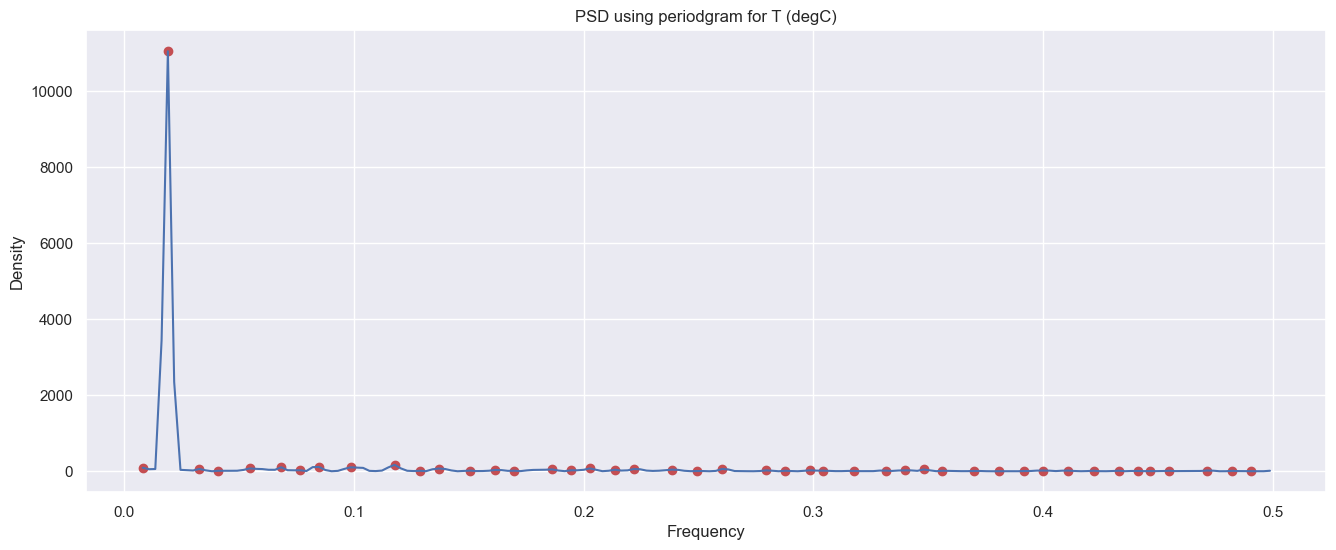

Frequency       Density     Period
0   0.019178  11059.782553  52.142857
1   0.117808    169.316720   8.488372
2   0.084932    113.229485  11.774194
3   0.068493    105.509285  14.600000
4   0.098630    103.482978  10.138889

In [25]:
#create a dizio to save the period
dizio_period = {}


###Retrieve the seasonlity by using the periodogram and getting the most used frequencies.
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], 1, detrend=None, window='hann', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]

#Find the peaks of the periodogram.
#peaks = signal.find_peaks(Pxx_per[f_per >= 0], prominence=(Pxx_per) * 0.001)[0]
peaks = signal.find_peaks(Pxx_per[f_per >= 0])[0]
peak_freq = f_per[peaks]
peak_dens = Pxx_per[peaks]

#Plot of the analysis transformation and of its peaks. Only the first five are interestings
fig = plt.figure(figsize=(16,6))
plt.plot(peak_freq, peak_dens, 'ro')
plt.plot(f_per[2:],Pxx_per[2:])
plt.xlabel('Frequency')
plt.ylabel('Density')
plt.title(f'PSD using periodgram for T (degC)')
plt.show()

#Retrieving of the values
data = {'Frequency': peak_freq, 'Density': peak_dens, 'Period': 1/peak_freq}
df = pd.DataFrame(data) #ATTENZIONE ORDINARE PER DENISTA
df.sort_values('Density', ascending=False, inplace=True, ignore_index=True)
display(df.head()) #come possimao vedere il più frequete è 12

dizio_period['T (degC)'] = df.loc[0,'Period']

In [26]:
dizio_period

{'T (degC)': 52.14285714285714}

confirmed anual seasonal -> periodicity of 52 week

#### test 2

In [27]:
'''for column in Weather_data_wk:
    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
    Fs = 1 # our unit of measures is "months", thus 1 per month
    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window='boxcar',return_onesided=True,scaling='density')
    f_per = f_per[1:]
    Pxx_per = Pxx_per[1:]
    plt.plot(f_per,Pxx_per)
    plt.xlabel('Frequency [cycles/month]')
    plt.title(column)

    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
    peak_freq =  f_per[peaks]
    peak_power = Pxx_per[peaks]
    plt.plot(peak_freq, peak_power, 'ro')
    plt.show()

    data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
    df = pd.DataFrame(data)
    display(df)'''

'for column in Weather_data_wk:\n    # (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting\n    Fs = 1 # our unit of measures is "months", thus 1 per month\n    f_per, Pxx_per = signal.periodogram(Weather_data_wk[column],Fs,detrend=False,window=\'boxcar\',return_onesided=True,scaling=\'density\')\n    f_per = f_per[1:]\n    Pxx_per = Pxx_per[1:]\n    plt.plot(f_per,Pxx_per)\n    plt.xlabel(\'Frequency [cycles/month]\')\n    plt.title(column)\n\n    peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]\n    peak_freq =  f_per[peaks]\n    peak_power = Pxx_per[peaks]\n    plt.plot(peak_freq, peak_power, \'ro\')\n    plt.show()\n\n    data = {\'Freq\': peak_freq, \'Period\': 1/peak_freq, \'Power\': peak_power}\n    df = pd.DataFrame(data)\n    display(df)'

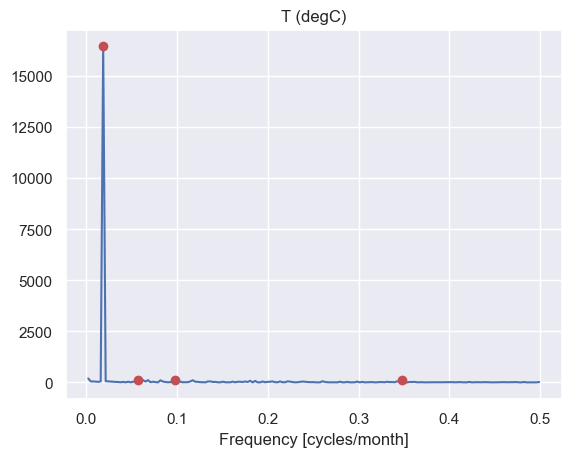

Freq     Period         Power
0  0.019178  52.142857  16456.709324
1  0.057534  17.380952    112.708219
2  0.098630  10.138889    115.229860
3  0.347945   2.874016    109.511200

In [28]:
# (Optional) Check with the frequency analysis (PSD) the frequency of the time series (train data), to conferm the seasonality value to be included in the forecasting
Fs = 1 # our unit of measures is "months", thus 1 per month
f_per, Pxx_per = signal.periodogram(Weather_data_wk_train['T (degC)'], Fs, detrend=False, window='boxcar', return_onesided=True, scaling='density')
f_per = f_per[1:]
Pxx_per = Pxx_per[1:]
plt.plot(f_per,Pxx_per)
plt.xlabel('Frequency [cycles/month]')
plt.title('T (degC)')

peaks = signal.find_peaks(Pxx_per[f_per >=0], prominence=100)[0]
peak_freq =  f_per[peaks]
peak_power = Pxx_per[peaks]
plt.plot(peak_freq, peak_power, 'ro')
plt.show()

data = {'Freq': peak_freq, 'Period': 1/peak_freq, 'Power': peak_power}
df = pd.DataFrame(data)
display(df)

# DESCRIBING THE TIME SERIES PATTERS

In [29]:
temp = Weather_data_wk_train['T (degC)']

## Stationarity

first we have to check the stationary of the time series, we do this becouse many statistical model require the series to be stationary to make effective and precise predictions. 
To check the stationary we can:
-   check mean and standard deviation (have to be constant over the time)
-   use the ACF (we can also spot presence of seasonality or trend)
-   statistical hypotesis test like ADF and KPSS

### Check mean and standard deviation (Rolling statistics)

Text(0.5, 1.0, 'Rolling Mean & Standard Deviation')

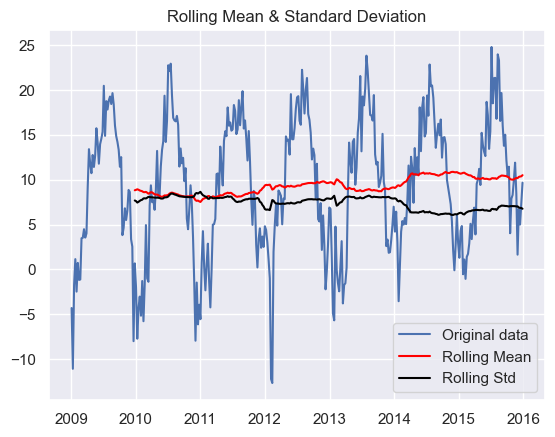

In [31]:
rolling_mean = temp.rolling(52).mean() #parameter window -> contain the lsat 52 observation (so 1 year) and calculate the mean  (CREDO)
rolling_std = temp.rolling(52).std()
plt.plot(temp, label='Original data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')

Like we can see form the plot the mean start to increse during the time so it is mean that maybe the series is not stationary also we see a cycle that it repeat every year, we have verified this in the frequency analisy.

For the standard deviation we can see that have a constant behaviour over the years maybe a small decline

### ACF and PACF

Can be use to identify possible components of the time series

Note: we know from frequancy analysis that for the feature T (dec) the seasonal periond is equal to 52

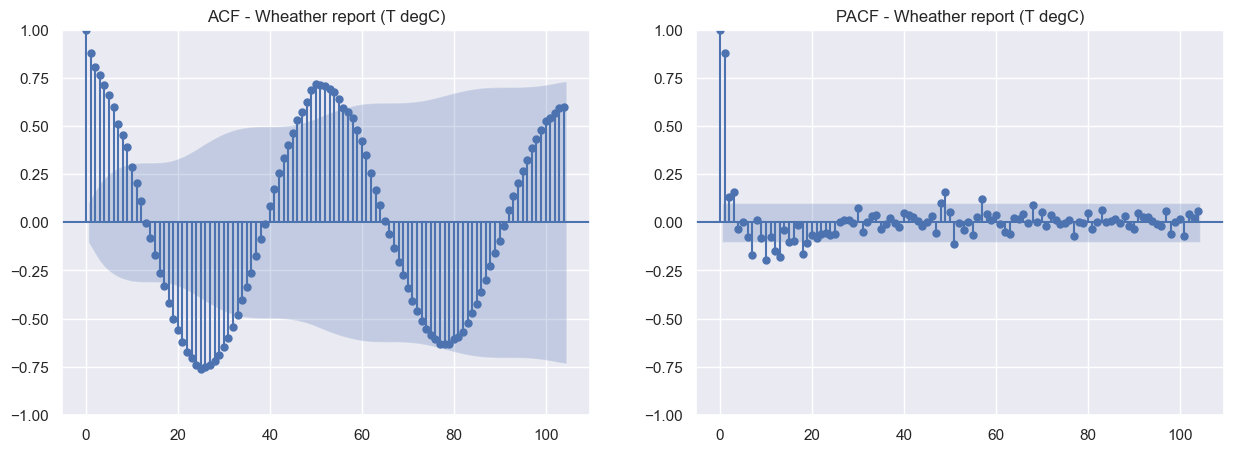

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(temp, lags=104, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp, lags=104, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

In this case we have a TS with a strong seasonal pattern so i decide to apply a seasonal differencing

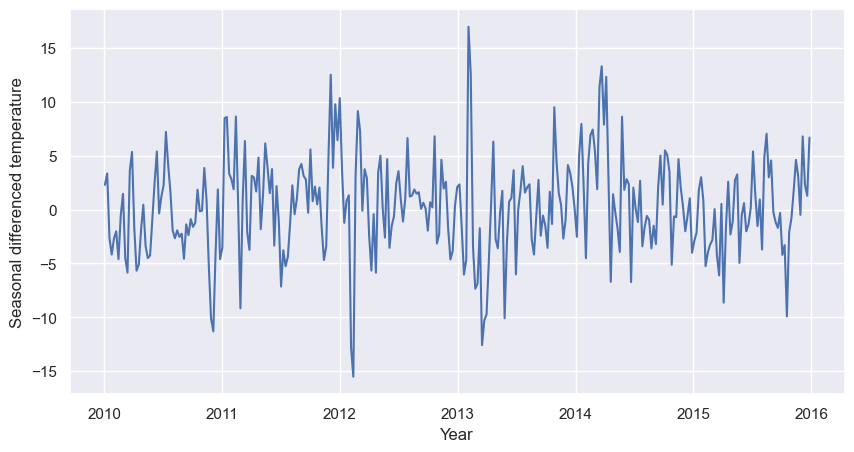

In [31]:
temp_diff = temp.diff(52).dropna()

plt.figure(figsize=(10,5))
plt.plot(temp_diff)
plt.xlabel('Year')
plt.ylabel('Seasonal differenced temperature')
plt.show()

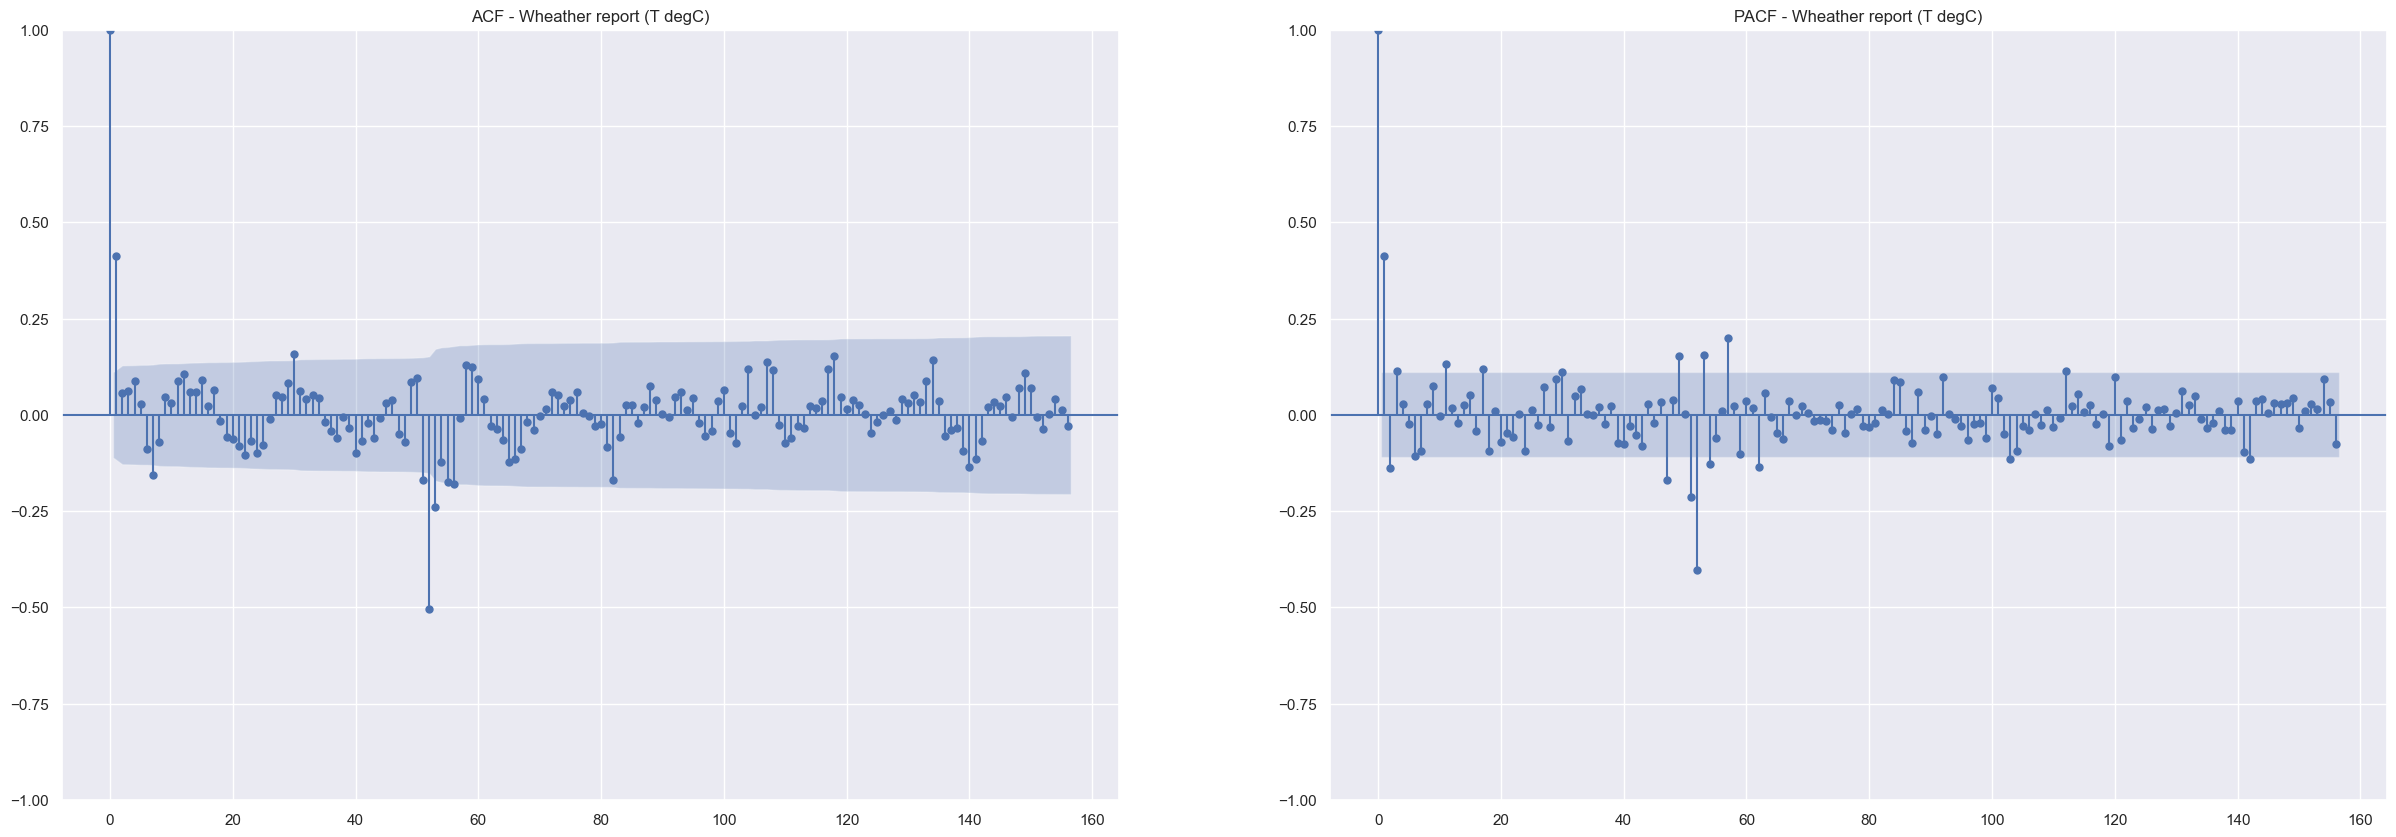

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(30,10))
plot_acf(temp_diff, lags=156, ax=ax[0], title='ACF - Wheather report (T degC)')
plot_pacf(temp_diff, lags=156, ax=ax[1], title='PACF - Wheather report (T degC)')
plt.show()

-   first non seasonal part (before lag 52): if i start with the ACF we have a rapid decrise so maybe a MA and the only significant spike is at lag 1 so MA(1); if i start from the PACF there is an instant decrise so maybe an AR the significant peak is until lag 3 so AR(3).
-   second i look at the seasonal part (so behaviour at 52 lag and the multiples): first ACF and it drops instantly with only one peak, no other in the multiple lags; from the PACF at least AR(1) or AR(2)

at the end i try to combine the different part at i will test SARIMA(3,0,1)(1,1,0,52) / SARIMA(3,0,1)(2,1,0,52)

Try also -> SARIMA(1,0,3)(1,1,2,52) sembra buono ma non in linea con quallo presente nell acf and pacf

### ADF and KPSS

In [33]:
# ADF test
adf_test = adfuller(temp,autolag='AIC') 
print('ADF Statistic:', adf_test[0])
print('p-value - ADF: ', adf_test[1])
print('------------------------------')

# p > 0.05 --> We reject the null hypothesis, meaning the data is not-stationary, as expected from the plot

# KPSS test option 1
kpss_test = kpss(temp, regression='c', nlags='auto', store=True) 
print('KPSS Statistic - c:', kpss_test[0])
print('p-value - c: ', kpss_test[1])
print('------------------------------')

# p < 0.05 --> We reject the null hypothesis, meaning the data is non-stationary.
# This because the "c" option tests for stationarity around a ‘mean’ only

# KPSS test option 2
kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)
print('KPSS Statistic - ct:', kpss_test[0])
print('p-value - ct: ', kpss_test[1])
print('------------------------------')

# p > 0.05 --> We can not reject the null hypothesis, meaning the data is trend stationary

ADF Statistic: -7.945514086336788
p-value - ADF:  3.2279831966229144e-12
------------------------------
KPSS Statistic - c: 0.10545784665825468
p-value - c:  0.1
------------------------------
KPSS Statistic - ct: 0.020274605447635607
p-value - ct:  0.1
------------------------------


C:\Users\elped\AppData\Local\Temp\ipykernel_2720\690312634.py:10: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='c', nlags='auto', store=True)
C:\Users\elped\AppData\Local\Temp\ipykernel_2720\690312634.py:19: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(temp, regression='ct', nlags='auto', store=True)


In [34]:
def kpss_test(data):
  kpss_out = kpss(data,regression='c', nlags='auto', store=True)
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> unit root, data is not stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Temperature')
kpss_test(temp)


KPSS on Temperature
KPSS Statistic: 0.10545784665825468
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


C:\Users\elped\AppData\Local\Temp\ipykernel_2720\4054022506.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_out = kpss(data,regression='c', nlags='auto', store=True)


In [35]:
# ADF on the different data from previous examples

def adfuller_test(data):
  adf_test = adfuller(data,autolag='AIC') # AIC is the default option
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Temperature')
adfuller_test(temp)
# p > 0.05 --> We cannot reject the null hypothesis (H0), meaning data the data has a unit root and is non-stationary.
# p <= 0.05 --> We reject the null hypothesis (H0), meaning data the data has not a unit root and is stationary.

ADF on Temperature
ADF Statistic: -7.945514086336788
p-value:  3.2279831966229144e-12
Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
We can reject the null hypothesis (H0) --> data is stationary


From the test the time series is alredy stationary so in reality we can't apply seasonal differenciation. It means that the mean, the variance and the covariance remain constant during all the time (we can also say that they are not depend on the time)

## Decomposition

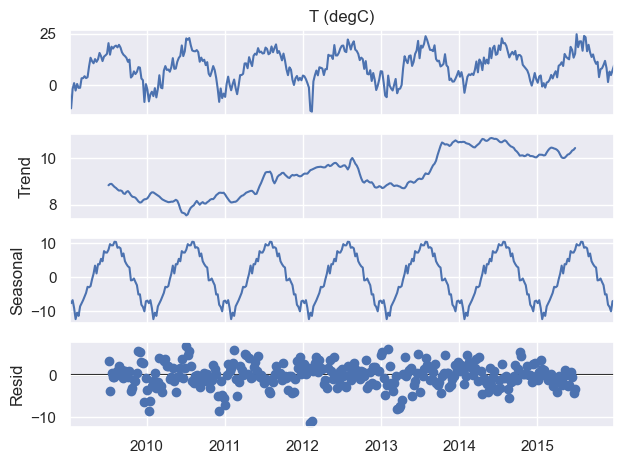

In [36]:
decompose_data_add = seasonal_decompose(Weather_data_wk_train['T (degC)'], model='additive', period = int(dizio_period['T (degC)'])) # period is automatically set to 12, considering the monthly data
decompose_data_add.plot()
plt.show()

# FORECASTING

In [37]:
# feature to forecast
feature = 'T (degC)'

In [38]:
#final test and train
train = Weather_data_wk_train[feature]
#display(train)
test = Weather_data_wk_test[feature]
#display(test)

In [39]:
#df to take track of the precision of the models
df_accuracy = pd.DataFrame(columns=['Model','AIC','RMSE','MAE'])
display(df_accuracy)

Empty DataFrame
Columns: [Model, AIC, RMSE, MAE]
Index: []

## Simple forecasting approaches

### Mean method

In [40]:
# 1) Mean method --> the forecasts of all future values are equal to the average of the historical data
model_average = HistoricAverage()
model_average = model_average.fit(train)
#forecast_values = model_average.prediction_intervals(start = test.index[0], end=test.index[-1])
forecast_values = model_average.predict(len(test))
#display(forecast_values['mean'])

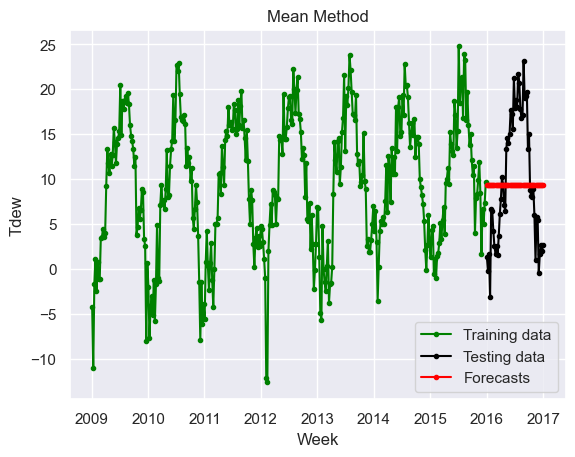

In [41]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index,forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Mean Method')
plt.legend()
plt.show()

### Naive method

In [42]:
#Naive Method --> we simply set all forecasts to be the value of the last observation
# Model, fitting and forecasting (20 samples)
model_Naive = Naive()
model_Naive = model_Naive.fit(train)
forecast_values = model_Naive.predict(len(test)) # same forecasting horizon as before
# forecast_values: Dictionary with entries mean for point predictions
#display(forecast_values['mean'])


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\utils.py:297: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fcst = {"mean": _repeat_val(val=y[-1], h=h)}


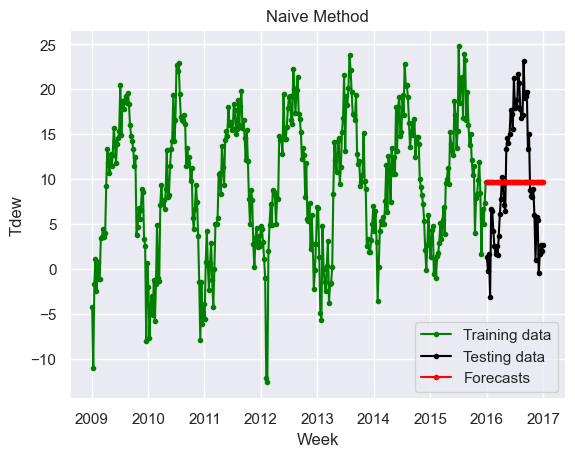

In [43]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Naive Method')
plt.legend()
plt.show()

### Seasonal Naive method

In [44]:
# Seasonal Naive Method --> similar to the naive, but uses the last known observation of the same period
model_Seasonal = SeasonalNaive(season_length=52) # seasonality has to be specified
model_Seasonal = model_Seasonal.fit(train)
forecast_values = model_Seasonal.predict(len(test)) # same forecasting horizon as before
# forecast_values: Dictionary with entries mean for point predictions
#display(forecast_values['mean'])

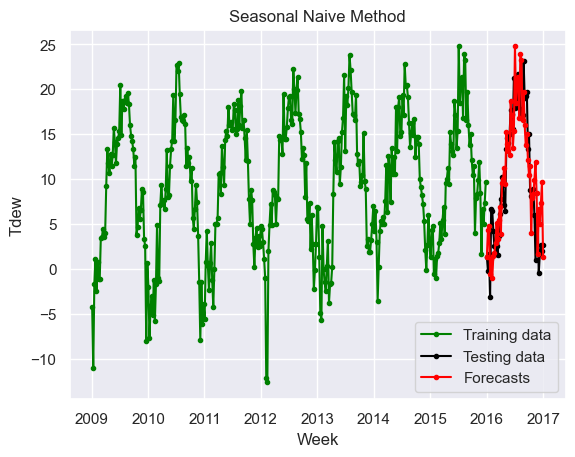

In [45]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Seasonal Naive Method')
plt.legend()
plt.show()

In [46]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Seasonal Naive Method', 'AIC':'', 'RMSE':root_mean_squared_error(test, forecast_values['mean']), 'MAE':mean_absolute_error(test, forecast_values['mean'])},index=[0])], ignore_index=True)

C:\Users\elped\AppData\Local\Temp\ipykernel_2720\3951454795.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Seasonal Naive Method', 'AIC':'', 'RMSE':root_mean_squared_error(test, forecast_values['mean']), 'MAE':mean_absolute_error(test, forecast_values['mean'])},index=[0])], ignore_index=True)


### Drift method

In [47]:
# Drift Method --> variation on naive, it allows the forecasts to increase or decrease over time (amout of change is called drift)
# Model, fitting and forecasting (20 samples)
model_Drift = RandomWalkWithDrift()
model_Drift = model_Drift.fit(train)
forecast_values = model_Drift.predict(len(test)) # same forecasting horizon as before

#display(forecast_values['mean'])


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3019: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  slope = (y[-1] - y[0]) / (y.size - 1)
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3020: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mean = slope * (1 + np.arange(h, dtype=y.dtype)) + y[-1]
c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsforecast\models.py:3024: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tre

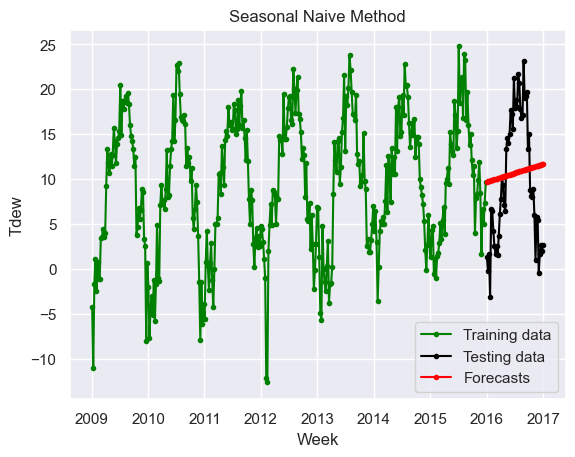

In [48]:
plt.figure()
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot(test.index, forecast_values['mean'], color='red', marker = '.', label='Forecasts' )
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Seasonal Naive Method')
plt.legend()
plt.show()

## Exponential Smoothing Additive Single

In [49]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAS = ETSModel(train, error='add').fit()
#make the prediction
pred = modelESAS.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAS = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAS['mean']

#df_modelESAS = np.exp(df_modelESAS) #nel caso venga fatto il log!!

In [50]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESAS.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESAS.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAS.index, df_modelESAS['pi_lower'], df_modelESAS['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [51]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Single', 'AIC':modelESAS.aic, 'RMSE':root_mean_squared_error(test, df_modelESAS['mean']), 'MAE':mean_absolute_error(test, df_modelESAS['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive Double

In [52]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESADouble = ETSModel(train, error='add', trend = 'add', damped_trend=False).fit()
#make the prediction
pred = modelESADouble.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESADouble = pred.summary_frame()
#take the forecasting
forecasts = df_modelESADouble['mean']

#df_modelESADouble = np.exp(df_modelESADouble) #nel caso venga fatto il log!!

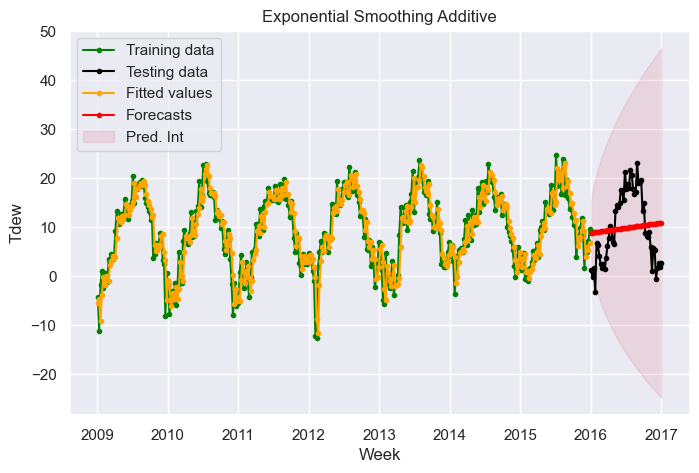

In [53]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESADouble.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESADouble.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESADouble.index, df_modelESADouble['pi_lower'], df_modelESADouble['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [54]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive Double', 'AIC':modelESADouble.aic, 'RMSE':root_mean_squared_error(test, df_modelESADouble['mean']), 'MAE':mean_absolute_error(test, df_modelESADouble['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Additive

NOTE: Models with multiplicative errors are useful for strictly positive data, but are not numerically stable with data containing zeros or negative values like in this case.
So we will test EST(A,A,Ad) and EST(A,A,A)

In [55]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESA = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=False).fit()
#make the prediction
pred = modelESA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESA = pred.summary_frame()
#take the forecasting
forecasts = df_modelESA['mean']

#df_modelESA = np.exp(df_modelESA) #nel caso venga fatto il log!!

c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


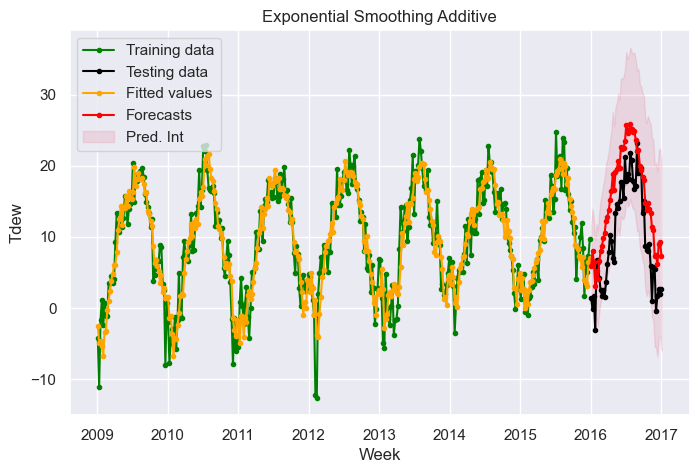

In [56]:
# Visualization
plt.figure(figsize=(8,5))
#plt.plot(np.exp(train), color='green',marker = '.',label='Training data')
plt.plot(train, color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
#plt.plot(np.exp(modelESA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(modelESA.fittedvalues,color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESA.index, df_modelESA['pi_lower'], df_modelESA['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Week')
plt.ylabel('Tdew')
plt.title('Exponential Smoothing Additive')
plt.legend()
plt.show()

In [57]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing Additive', 'AIC':modelESA.aic, 'RMSE':root_mean_squared_error(test, df_modelESA['mean']), 'MAE':mean_absolute_error(test, df_modelESA['mean'])},index=[0])], ignore_index=True)

## Exponential Smoothing Addictive Damped Trend True

In [58]:
#apply trasformation on the train
#train = np.log(train)

#cration of the model
modelESAd = ETSModel(train, error='add', trend = 'add', seasonal='add', seasonal_periods=52, damped_trend=True).fit()
#make the prediction
pred = modelESAd.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelESAd = pred.summary_frame()
#take the forecasting
forecasts = df_modelESAd['mean']

#df_modelESAd = np.exp(df_modelESAd) #nel caso venga fatto il log!!


c:\Users\elped\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [59]:
modelESAd.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               T (degC)   No. Observations:                  365
Model:                      ETS(AAdA)   Log Likelihood                -903.420
Date:                Mon, 20 Jan 2025   AIC                           1924.839
Time:                        23:09:45   BIC                           2154.933
Sample:                    01-04-2009   HQIC                          2016.282
                         - 12-27-2015   Scale                            8.268
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2146      0.071      3.022      0.003       0.075       0.354
smoothing_trend      2.146e-05        nan        nan        nan         nan         nan
smoothing_seasonal   7.854e-05        nan        nan        nan         nan         nan
damping_trend           0.8000        nan        nan        nan         nan         nan
initial_level          -8.5992   3.05e+04     -0.000      1.000   -5.97e+04    5.97e+04
initial_trend           3.5962        nan        nan        nan         nan         nan
initial_seasonal.0     -0.6967   3.05e+04  -2.29e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.1     -3.5479   3.05e+04     -0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.2     -2.1908   3.05e+04  -7.19e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.3     -2.3830   3.05e+04  -7.82e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.4      1.2223   3.05e+04   4.01e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.5      1.6543   3.05e+04   5.43e-05      1.000   -5.97e+04    5.97e+04
initial_seasonal.6      3.7286   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.7      4.2905   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.8      5.1216   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.9      4.1908   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.10     5.1720   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.11     8.2926   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.12     8.8398   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.13     9.8191   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.14    10.3734   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.15    12.6412   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.16    12.4443   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.17    14.0304   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.18    15.2757   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.19    15.2199   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.20    15.6563   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.21    16.3659   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.22    15.4637   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.23    15.0462   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.24    16.2252   3.05e+04      0.001      1.000   -5.97e+04    5.97e+04
initial_seasonal.25    13.9050   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.26    12.9474   3.05e+04      0.000      1.000   -5.97e+04    5.97e+04
initial_seasonal.27    12.8299   3.05e+04      0.000      1.000   -5.97e+

In [60]:
#df_modelESAd

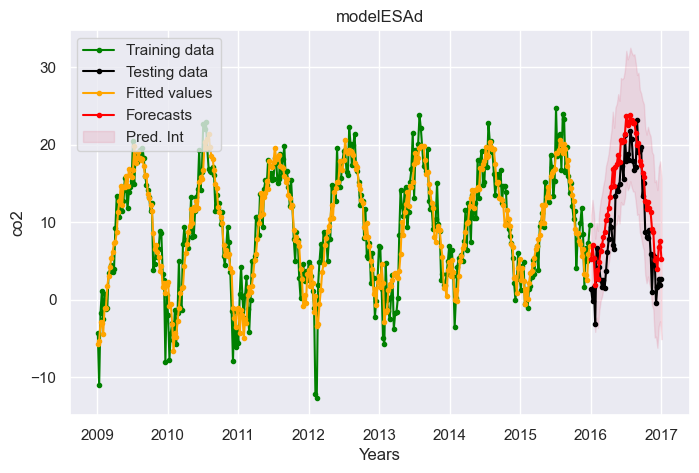

In [61]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((modelESAd.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelESAd.index, df_modelESAd['pi_lower'], df_modelESAd['pi_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('co2')
plt.title('modelESAd')
plt.legend()
plt.show()

In [62]:
#save the accuracy
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Exponentian Smoothing AD', 'AIC':modelESAd.aic, 'RMSE':root_mean_squared_error(test, df_modelESAd['mean']), 'MAE':mean_absolute_error(test, df_modelESAd['mean'])},index=[0])], ignore_index=True)

## Linear Regression

## Manual SARIMA

So we have to decide the parameter for the AR part, MA part, I and Seasonal. See ACF and PACF part for parameters


In [90]:
#SARIMA(3,0,1)(1,1,0,52) / SARIMA(3,0,1)(2,1,0,52)

#test 1
#(p, d, q) = (3,0,1)
#(P, D, Q, S) = (1,1,0,52)

#test 2
(p, d, q) = (3,0,1)
(P, D, Q, S) = (2,1,0,52)

#test 3
#(p, d, q) = (1,0,3)
#(P, D, Q, S) = (1,1,2,52)

#test 4 (decide after check the summary() of the model, the ar3 is useless)
#at the end a little bit more precise but the time for the creation is LESS of the test 1 (from 5 min to 44 sec)
#(p, d, q) = (2,0,1)
#(P, D, Q, S) = (1,1,0,52)

In [91]:
#creation of the model manual SARIMA
model_manual_SARIMA = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

In [92]:
model_manual_SARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                            T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 1)x(2, 1, [], 52)   Log Likelihood                -826.642
Date:                             Mon, 20 Jan 2025   AIC                           1667.284
Time:                                     23:23:07   BIC                           1693.507
Sample:                                 01-04-2009   HQIC                          1677.763
                                      - 12-27-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1559      0.254     -0.615      0.539      -0.653       0.341
ar.L2          0.1493      0.126      1.185      0.236      -0.098       0.396
ar.L3          0.0432      0.081      0.530      0.596      -0.116       0.203
ma.L1          0.6412      0.242      2.655      0.008       0.168       1.115
ar.S.L52      -0.6473      0.053    -12.296      0.000      -0.750      -0.544
ar.S.L104     -0.1827      0.073     -2.506      0.012      -0.326      -0.040
sigma2        10.7279      0.706     15.190      0.000       9.344      12.112
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                21.05
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                            -0.04
Prob(H) (two-sided):                  0.83   Kurtosis:                         4.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

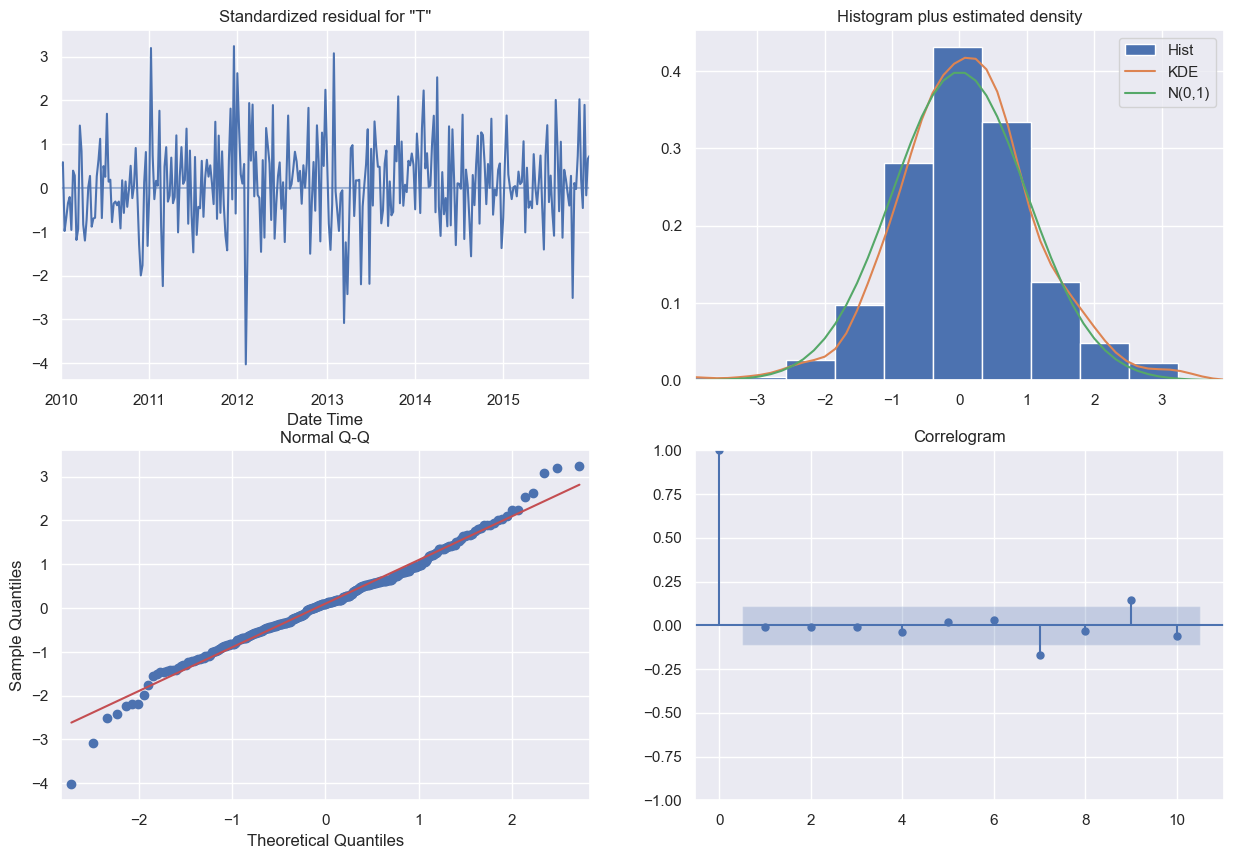

In [93]:
model_manual_SARIMA.plot_diagnostics(figsize=(15,10))
plt.show()

In [94]:
#forecasting
pred = model_manual_SARIMA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_manual_modelSARIMA = pred.summary_frame()
#take the forecasting
forecasts = df_manual_modelSARIMA['mean']


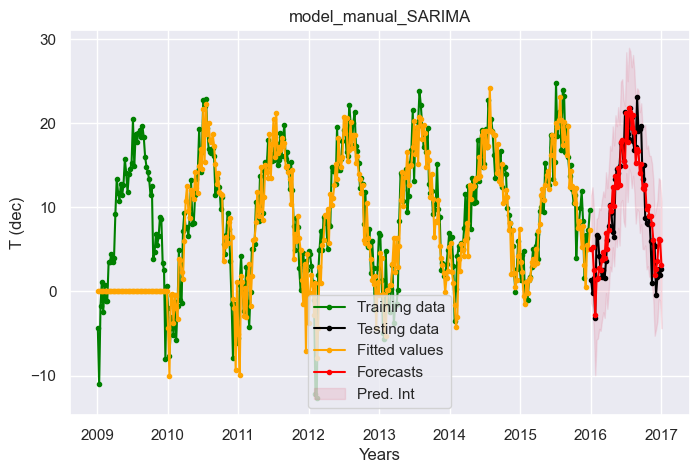

In [95]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_manual_SARIMA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_manual_modelSARIMA.index, df_manual_modelSARIMA['mean_ci_lower'], df_manual_modelSARIMA['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('model_manual_SARIMA')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [96]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Manual Sarima', 'AIC':model_manual_SARIMA.aic, 'RMSE':root_mean_squared_error(test, df_manual_modelSARIMA['mean']), 'MAE':mean_absolute_error(test, df_manual_modelSARIMA['mean'])},index=[0])], ignore_index=True)

## Auto SARIMA (Auto_Arima)

we have see from the adf and kpss that the ts is alredy stationary so its mean that the d = 0 and D = 0 beacouse we don't have to differencing!!

In [70]:
'''stepwise_model = auto_arima(train, start_p=0, start_q=0, d=0,
                           max_p=5, max_q=5, m=52,
                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,
                           trace=True, information_criterion='aic',
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True) #TRUE altrimenti ci impiega troppo #ATTENZIONE PROVARE A MAETTERE D=1 E d=0'''

"stepwise_model = auto_arima(train, start_p=0, start_q=0, d=0,\n                           max_p=5, max_q=5, m=52,\n                           start_P=0, start_Q=0, max_P = 5, max_Q = 5, D = 0, seasonal=True,\n                           trace=True, information_criterion='aic',\n                           error_action='ignore',\n                           suppress_warnings=True,\n                           stepwise=True) #TRUE altrimenti ci impiega troppo #ATTENZIONE PROVARE A MAETTERE D=1 E d=0"

but now i try to use auto_arima with d and D equal to None so the algorithm will determine they. From waht we know also in this case the d and D have to be equal to 0

In [71]:
'''stepwise_model = auto_arima(train, 
                            start_p=0, start_q=0, d= None,
                            max_p=5, max_q=5, 
                            m=52,
                            start_P=0, start_Q=0, D = None,
                            max_P = 5, max_Q = 5, 
                            seasonal=True,
                            trace=True, 
                            information_criterion='aic',
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)'''

"stepwise_model = auto_arima(train, \n                            start_p=0, start_q=0, d= None,\n                            max_p=5, max_q=5, \n                            m=52,\n                            start_P=0, start_Q=0, D = None,\n                            max_P = 5, max_Q = 5, \n                            seasonal=True,\n                            trace=True, \n                            information_criterion='aic',\n                            error_action='ignore',\n                            suppress_warnings=True,\n                            stepwise=True)"

In [72]:
#best oarameters
#Best model:  ARIMA(3,0,0)(2,0,0)[52] intercept
#(p, d, q) = stepwise_model.order
#(P, D, Q, S) = stepwise_model.seasonal_order
(p, d, q) = (3,0,0)
(P, D, Q, S) = (2,0,0,52)

In [73]:
#creation of the model SARIMA
model_SARIMA = SARIMAX(train, order=(p,d,q), seasonal_order=(P,D,Q,S)).fit()

In [74]:
model_SARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -956.476
Date:                            Mon, 20 Jan 2025   AIC                           1924.952
Time:                                    23:10:59   BIC                           1948.352
Sample:                                01-04-2009   HQIC                          1934.252
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7058      0.050     14.105      0.000       0.608       0.804
ar.L2          0.0125      0.063      0.198      0.843      -0.111       0.136
ar.L3          0.2295      0.045      5.049      0.000       0.140       0.319
ar.S.L52       0.1494      0.051      2.948      0.003       0.050       0.249
ar.S.L104      0.2181      0.057      3.843      0.000       0.107       0.329
sigma2        10.7842      0.679     15.877      0.000       9.453      12.116
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                14.61
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                            -0.09
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

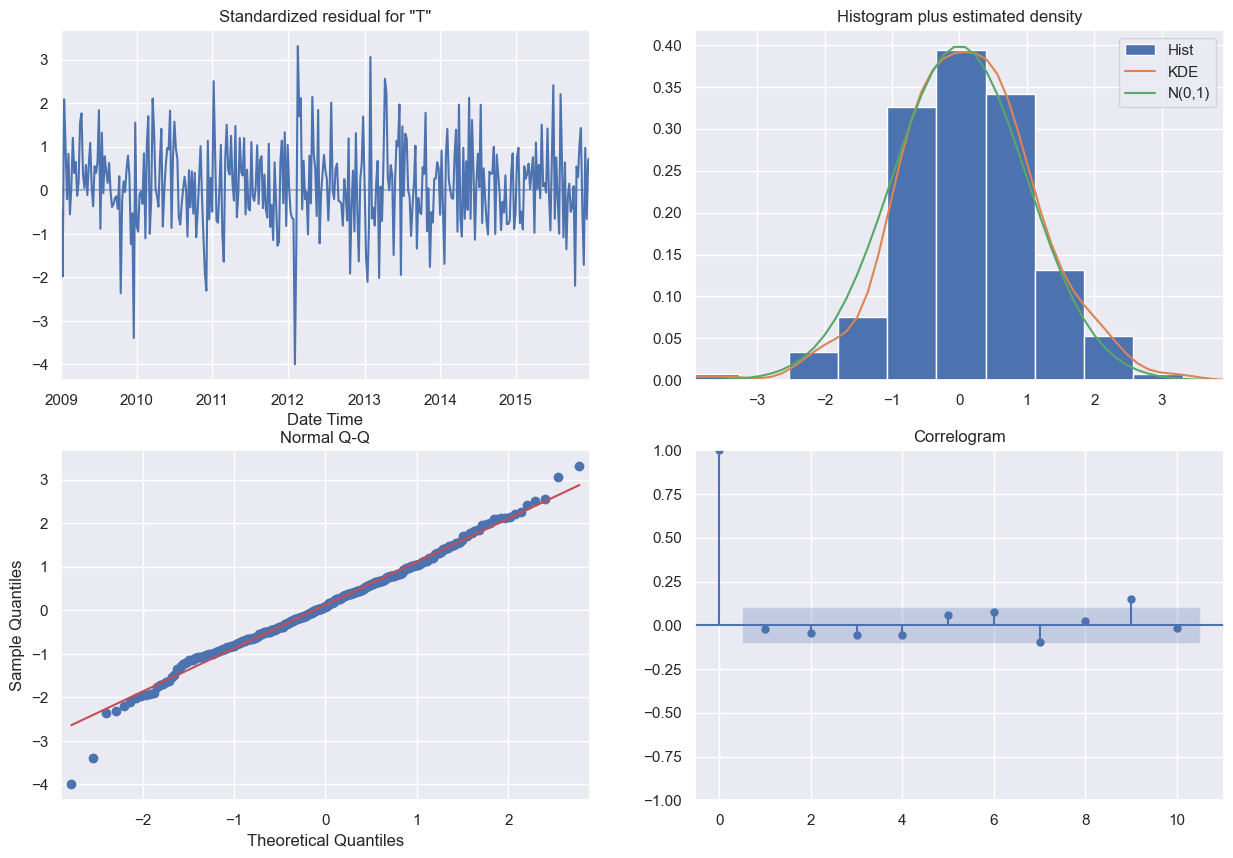

In [75]:
model_SARIMA.plot_diagnostics(figsize=(15,10))
plt.show()

form the diagnosis we can see that the residual are similar to a normal so there aren't missing time pattern

In [76]:
#forecasting
pred = model_SARIMA.get_prediction(start=test.index[0], end=test.index[-1])
#summary of the model
df_modelSARIMA = pred.summary_frame()
#take the forecasting
forecasts = df_modelSARIMA['mean']


In [77]:
#df_modelSARIMA['mean']

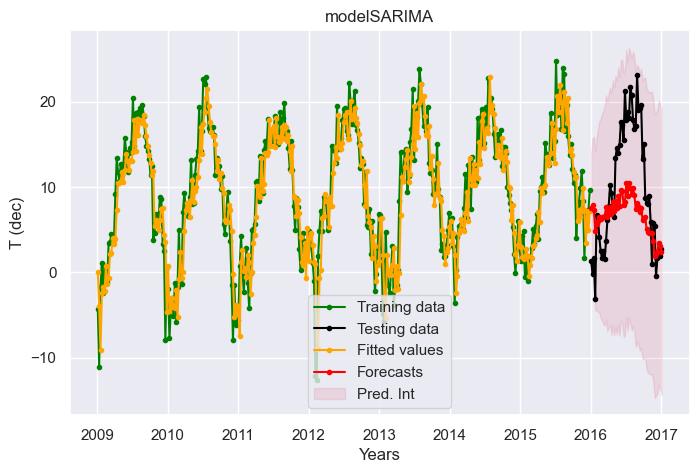

In [78]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_SARIMA.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelSARIMA.index, df_modelSARIMA['mean_ci_lower'], df_modelSARIMA['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('modelSARIMA')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [79]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'Auto_Arima + Sarima', 'AIC':model_SARIMA.aic, 'RMSE':root_mean_squared_error(test, df_modelSARIMA['mean']), 'MAE':mean_absolute_error(test, df_modelSARIMA['mean'])},index=[0])], ignore_index=True)

## SARIMAX

per sarima max decido di utilizzare gli stessi parametri che mi ha ritornato auto_arima per quanto riguarda the exogenous variable decido di prendere le feature con la correlazione più alta con T (deg C) ovviamente non inserisco le feature che sono uguali a T ma con unità di misura diverse

In [80]:
#save the parameter
(p, d, q) = (3,0,0)
(P, D, Q, S) = (2,0,0,52)

correlazioni importanti per creare exogenouse variables per T (degC):
-   VPmax (mbar) = Saturation vapor pressure
-   VPact (mbar) = Vapor pressure
-   sh (g/kg) = Specific humidity
-   H2OC (mmol/mol) = Water vapor concentration
-   rho (g/m**3) = Airtight

In [81]:
#create the exogenous variables
exo_var = pd.concat([Weather_data_wk_train['VPmax (mbar)'], Weather_data_wk_train['VPact (mbar)'], Weather_data_wk_train['sh (g/kg)'], Weather_data_wk_train['H2OC (mmol/mol)'], Weather_data_wk_train['rho (g/m**3)']], axis=1)
#display(exo_var)

exo_var_test = pd.concat([Weather_data_wk_test['VPmax (mbar)'], Weather_data_wk_test['VPact (mbar)'], Weather_data_wk_test['sh (g/kg)'], Weather_data_wk_test['H2OC (mmol/mol)'], Weather_data_wk_test['rho (g/m**3)']], axis=1)
#display(exo_var_test)

In [82]:
model_SARIMAX = SARIMAX(train,
                        order = (p,d,q),
                        seasonal_order= (P, D, Q, S),
                        exog=exo_var).fit()

In [83]:
model_SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           T (degC)   No. Observations:                  365
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 52)   Log Likelihood                -385.198
Date:                            Mon, 20 Jan 2025   AIC                            792.395
Time:                                    23:13:10   BIC                            835.294
Sample:                                01-04-2009   HQIC                           809.444
                                     - 12-27-2015                                         
Covariance Type:                              opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
VPmax (mbar)        0.8330      0.018     47.543      0.000       0.799       0.867
VPact (mbar)        0.4205      0.929      0.453      0.651      -1.401       2.242
sh (g/kg)        -379.3455      7.087    -53.527      0.000    -393.236    -365.455
H2OC (mmol/mol)   237.8880      4.507     52.781      0.000     229.054     246.722
rho (g/m**3)       -0.0120      0.000    -78.980      0.000      -0.012      -0.012
ar.L1               0.3171      0.040      7.975      0.000       0.239       0.395
ar.L2               0.1219      0.048      2.532      0.011       0.028       0.216
ar.L3               0.0691      0.054      1.268      0.205      -0.038       0.176
ar.S.L52            0.2065      0.055      3.732      0.000       0.098       0.315
ar.S.L104           0.0546      0.062      0.885      0.376      -0.066       0.176
sigma2              0.4708      0.031     15.372      0.000       0.411       0.531
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                33.00
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               1.21   Skew:                             0.16
Prob(H) (two-sided):                  0.29   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

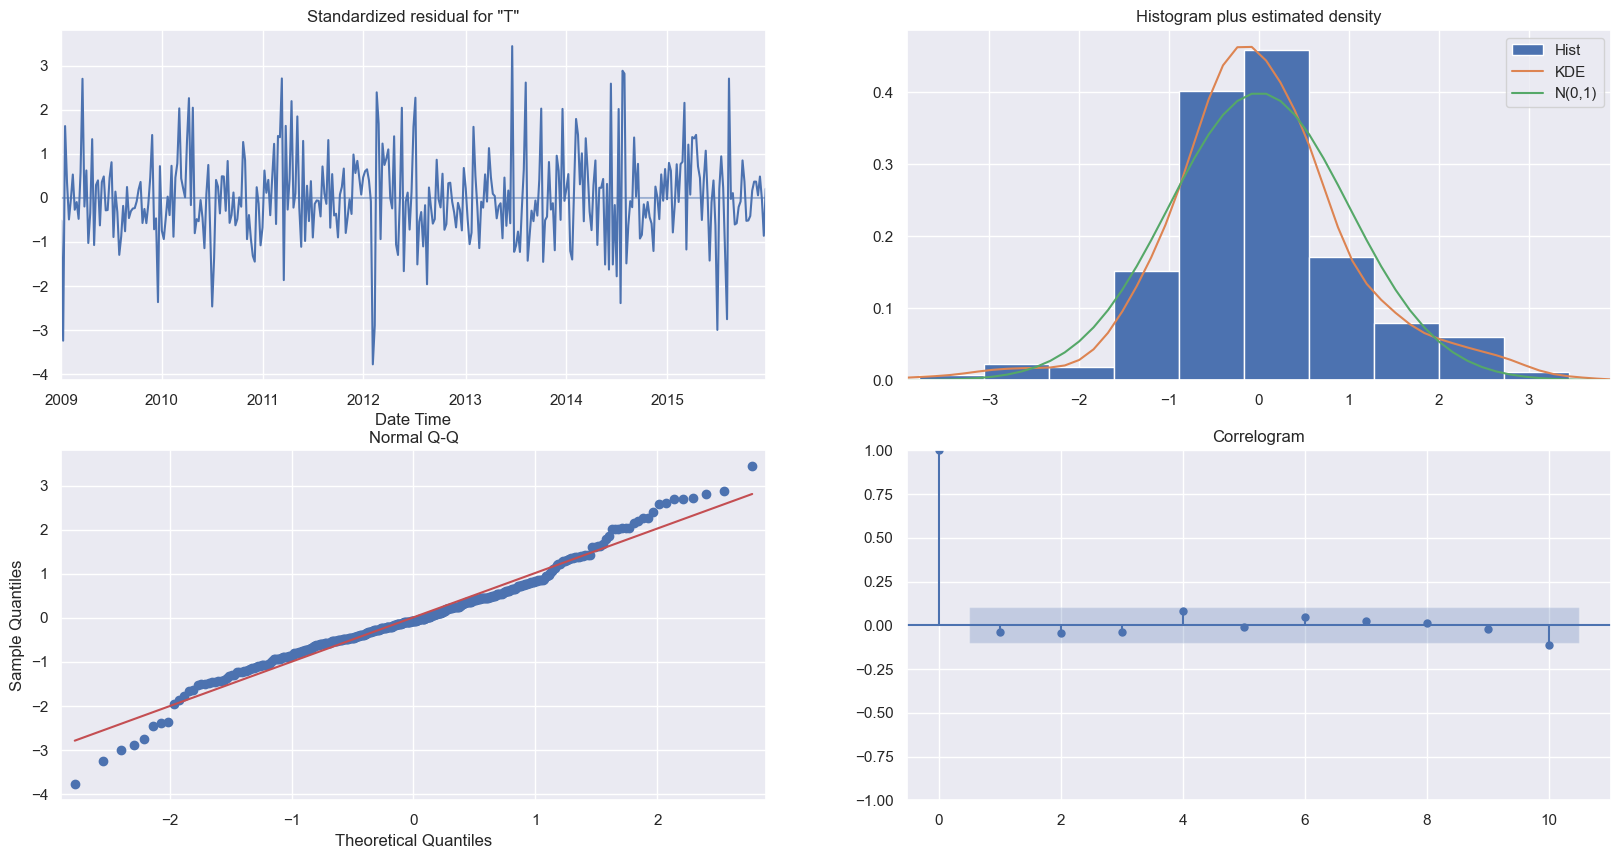

In [84]:
model_SARIMAX.plot_diagnostics(figsize=(20,10))
plt.show()

In [85]:
#forecasting
pred = model_SARIMAX.get_prediction(start=test.index[0], end=test.index[-1], exog=exo_var_test)
#summary of the model
df_modelSARIMAX = pred.summary_frame()
#take the forecasting
forecasts = df_modelSARIMAX['mean']

è corretto mettere nel get prediction exog = le variabili exog con già i risultati?? che senso a prevedere qualcosa con delle altre variabili già ottenute?? non è impossibile fare questa cosa in un contesto reale?? oopure si può fare -> cioè gli exog sono anche loro delle predizioni calcolate in precedenza?? quindi prima predico gli exog poi li uso per prevedere il tempo??

In [86]:
# Visualization #PER IL PLTO RI TRASFORMARE I DATI CON L'ESPONENZIALE!!!!!
plt.figure(figsize=(8,5))
plt.plot((train), color='green',marker = '.',label='Training data')
plt.plot(test, color='black', marker = '.',label='Testing data')
plt.plot((model_SARIMAX.fittedvalues),color='orange', marker = '.', label='Fitted values')
plt.plot(forecasts, color='red', marker = '.', label='Forecasts')
plt.fill_between(df_modelSARIMAX.index, df_modelSARIMAX['mean_ci_lower'], df_modelSARIMAX['mean_ci_upper'], alpha=.1, color='crimson', label='Pred. Int')
plt.xlabel('Years')
plt.ylabel('T (dec)')
plt.title('modelSARIMAX')
plt.legend()
plt.show()

#ATTENZIONE RIVEDERE!!!!!

In [87]:
df_accuracy = pd.concat([df_accuracy, pd.DataFrame({'Model':'SARIMAX', 'AIC':model_SARIMAX.aic, 'RMSE':root_mean_squared_error(test, df_modelSARIMAX['mean']), 'MAE':mean_absolute_error(test, df_modelSARIMAX['mean'])},index=[0])], ignore_index=True)

## VAR / VARMAX

##  Dispaly accuracy

In [97]:
df_accuracy

Model          AIC      RMSE       MAE
0                  Seasonal Naive Method               3.922163  3.131426
1  Exponentian Smoothing Additive Single   1945.43895  7.263913  6.306063
2  Exponentian Smoothing Additive Double  1949.383951  7.100954  6.359960
3         Exponentian Smoothing Additive   1932.58244  6.123421  5.627138
4               Exponentian Smoothing AD  1924.839365  4.519451  4.055855
5                          Manual Sarima  1669.194828  3.318977  2.720863
6                    Auto_Arima + Sarima  1924.952286  6.703710  5.489217
7                                SARIMAX   792.395291  0.623117  0.455321
8                          Manual Sarima  1667.283886  3.076766  2.442572

# NOTE

-   per la parte di stazionarità:
se il test adf e kpss al primo tentativo ci dice che è stazionario significa che non ce bisogno di applicare differenziazione (quindi integere I) sia per quanto rigurda il trend (d piccolo -> first differenziation) sia per la seasonalita (D grande -> seasonal differenziation).
Nel caso in cui sdf e kpss ritornino che la ts non è stazionario allora si può applicare una differenziazione; ci sono diversi modi: se la ts presenta una visibile seasonalità conviente prima applicare una seasonal differenzazion, applicare di nuovo adf/kpss se adesso è stazionario (D = 1 cioè basta applicare 1 volta la diff per avere stazio), se non è stazionario sempre sulla ts con season diff applicare anche la first diff, applicare adf/kpss se risulta stazio ( aggiungere anche d = 1). alla fine diff serve per comprendere i parametri d e D. (attenzione in ogni caso ho voluto applicare seasonal differenziazione per acf pacf e manual model)

-   per ACF e PACF:
ci sono 'due tipi' non seasonal dove il lag = seasonal e mi può aiutare a comprendere i parametri per un AR oppure MA -> (p,q). l'altro è il seasonl dove il lag > seasonal in questo modo possiamo cercare di interpretare i valori (P, Q) (parte della seasonal)

-   per ESM:
attenzione controllare perchè per quello singolo a quanto sembra per poterlo utilizzare devo prima seasonl differenziation perchè non lavora con la seasonalità!!!

-   per differenziation: Sometimes it is necessary to take both a seasonal difference and a first difference to obtain stationary data --> it makes no difference which is done first as the result will be the same. However, if the data have a strong seasonal pattern, seasonal differencing should be done first, as the resulting series will sometimes be already stationary.

- per quanto riguarda ARMA:
nel caso in cui fosse presente seasonalita, la cosa che possaimao fare è prendere il trand, togliere season (tran_diff_seas), adesso che è senaza season possimao applicare e costruire il modello ARIMA, fittarlo e prevedere (attenzione le predizioni sono senza season quindi bisogna riinserirli). adesso che abbiamo le pred dobbbiamo fare uno step in piu: prendi train trovati la seasonalità (seasonal naive) e adesso che abbimao anche la seasonalità possiamo aggiungeral alle pred cosi adesso abbiamo la predition fattta con ARMA + la seasnalità che mancava dalla pred di arima.

train -> train diff seas -> Arima -> pred with no season
+
train -> seasonal naive
= pred con seasonalità

-   Manual SARIMA con parametri (3,0,1)(1,1,0,52)  (test1)
<table class="simpletable">
<caption>SARIMAX Results</caption>
<tr>
  <th>Dep. Variable:</th>              <td>T (degC)</td>             <th>  No. Observations:  </th>    <td>365</td>  
</tr>
<tr>
  <th>Model:</th>           <td>SARIMAX(3, 0, 1)x(1, 1, [], 52)</td> <th>  Log Likelihood     </th> <td>-829.220</td>
</tr>
<tr>
  <th>Date:</th>                   <td>Sun, 19 Jan 2025</td>         <th>  AIC                </th> <td>1670.440</td>
</tr>
<tr>
  <th>Time:</th>                       <td>19:48:12</td>             <th>  BIC                </th> <td>1692.917</td>
</tr>
<tr>
  <th>Sample:</th>                    <td>01-04-2009</td>            <th>  HQIC               </th> <td>1679.423</td>
</tr>
<tr>
  <th></th>                          <td>- 12-27-2015</td>           <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th>Covariance Type:</th>               <td>opg</td>               <th>                     </th>     <td> </td>   
</tr>
</table>
<table class="simpletable">
<tr>
      <td></td>        <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>    <td>   -0.4384</td> <td>    0.087</td> <td>   -5.041</td> <td> 0.000</td> <td>   -0.609</td> <td>   -0.268</td>
</tr>
<tr>
  <th>ar.L2</th>    <td>    0.3029</td> <td>    0.061</td> <td>    4.947</td> <td> 0.000</td> <td>    0.183</td> <td>    0.423</td>
</tr>
<tr>
  <th>ar.L3</th>    <td>   -0.0521</td> <td>    0.067</td> <td>   -0.782</td> <td> 0.434</td> <td>   -0.183</td> <td>    0.078</td>
</tr>
<tr>
  <th>ma.L1</th>    <td>    0.9425</td> <td>    0.059</td> <td>   16.000</td> <td> 0.000</td> <td>    0.827</td> <td>    1.058</td>
</tr>
<tr>
  <th>ar.S.L52</th> <td>   -0.5423</td> <td>    0.042</td> <td>  -12.962</td> <td> 0.000</td> <td>   -0.624</td> <td>   -0.460</td>
</tr>
<tr>
  <th>sigma2</th>   <td>   11.0363</td> <td>    0.738</td> <td>   14.958</td> <td> 0.000</td> <td>    9.590</td> <td>   12.482</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Ljung-Box (L1) (Q):</th>     <td>0.01</td> <th>  Jarque-Bera (JB):  </th> <td>19.92</td>
</tr>
<tr>
  <th>Prob(Q):</th>                <td>0.92</td> <th>  Prob(JB):          </th> <td>0.00</td> 
</tr>
<tr>
  <th>Heteroskedasticity (H):</th> <td>1.01</td> <th>  Skew:              </th> <td>-0.02</td>
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.96</td> <th>  Kurtosis:          </th> <td>4.24</td> 
</tr>
</table><br/><br/>Warnings:<br/>[1] Covariance matrix calculated using the outer product of gradients (complex-step).



come possiamo vedere dalla tabella non sempra rilevante applicare 3 volte autoregressione (ar3 -> per essere significativi devono avere un p-value < 0.05), invece gli altri parametri sembrano andare bene; Jarque test??? quindi provo con ar 2 per la parte non seasonal

-   Manual SARIMA con parametri (2,0,1)(1,1,0,52)  (test 4)

<table class="simpletable">
<caption>SARIMAX Results</caption>
<tr>
  <th>Dep. Variable:</th>              <td>T (degC)</td>             <th>  No. Observations:  </th>    <td>365</td>  
</tr>
<tr>
  <th>Model:</th>           <td>SARIMAX(2, 0, 1)x(1, 1, [], 52)</td> <th>  Log Likelihood     </th> <td>-829.597</td>
</tr>
<tr>
  <th>Date:</th>                   <td>Mon, 20 Jan 2025</td>         <th>  AIC                </th> <td>1669.195</td>
</tr>
<tr>
  <th>Time:</th>                       <td>23:10:32</td>             <th>  BIC                </th> <td>1687.926</td>
</tr>
<tr>
  <th>Sample:</th>                    <td>01-04-2009</td>            <th>  HQIC               </th> <td>1676.680</td>
</tr>
<tr>
  <th></th>                          <td>- 12-27-2015</td>           <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th>Covariance Type:</th>               <td>opg</td>               <th>                     </th>     <td> </td>   
</tr>
</table>
<table class="simpletable">
<tr>
      <td></td>        <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>    <td>   -0.4412</td> <td>    0.089</td> <td>   -4.970</td> <td> 0.000</td> <td>   -0.615</td> <td>   -0.267</td>
</tr>
<tr>
  <th>ar.L2</th>    <td>    0.3164</td> <td>    0.062</td> <td>    5.083</td> <td> 0.000</td> <td>    0.194</td> <td>    0.438</td>
</tr>
<tr>
  <th>ma.L1</th>    <td>    0.9303</td> <td>    0.055</td> <td>   16.814</td> <td> 0.000</td> <td>    0.822</td> <td>    1.039</td>
</tr>
<tr>
  <th>ar.S.L52</th> <td>   -0.5454</td> <td>    0.041</td> <td>  -13.247</td> <td> 0.000</td> <td>   -0.626</td> <td>   -0.465</td>
</tr>
<tr>
  <th>sigma2</th>   <td>   11.0550</td> <td>    0.741</td> <td>   14.921</td> <td> 0.000</td> <td>    9.603</td> <td>   12.507</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Ljung-Box (L1) (Q):</th>     <td>0.03</td> <th>  Jarque-Bera (JB):  </th> <td>19.36</td>
</tr>
<tr>
  <th>Prob(Q):</th>                <td>0.87</td> <th>  Prob(JB):          </th> <td>0.00</td> 
</tr>
<tr>
  <th>Heteroskedasticity (H):</th> <td>1.00</td> <th>  Skew:              </th> <td>-0.03</td>
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.99</td> <th>  Kurtosis:          </th> <td>4.22</td> 
</tr>
</table><br/><br/>Warnings:<br/>[1] Covariance matrix calculated using the outer product of gradients (complex-step).



possiamo vedere che ce stato un miglioramento quasi inutile, minor aic, però la cosa che è migliorata di MOLTO è stato il tempo di creazione del modello passando da 5 minuti per quello precedente a 44 secondi per questo!!!!!

-   Manual SARIMA con parametri (3,0,1)(2,1,0,52)  (test 2)
<table class="simpletable">
<caption>SARIMAX Results</caption>
<tr>
  <th>Dep. Variable:</th>              <td>T (degC)</td>             <th>  No. Observations:  </th>    <td>365</td>  
</tr>
<tr>
  <th>Model:</th>           <td>SARIMAX(3, 0, 1)x(2, 1, [], 52)</td> <th>  Log Likelihood     </th> <td>-826.642</td>
</tr>
<tr>
  <th>Date:</th>                   <td>Mon, 20 Jan 2025</td>         <th>  AIC                </th> <td>1667.284</td>
</tr>
<tr>
  <th>Time:</th>                       <td>23:23:07</td>             <th>  BIC                </th> <td>1693.507</td>
</tr>
<tr>
  <th>Sample:</th>                    <td>01-04-2009</td>            <th>  HQIC               </th> <td>1677.763</td>
</tr>
<tr>
  <th></th>                          <td>- 12-27-2015</td>           <th>                     </th>     <td> </td>   
</tr>
<tr>
  <th>Covariance Type:</th>               <td>opg</td>               <th>                     </th>     <td> </td>   
</tr>
</table>
<table class="simpletable">
<tr>
      <td></td>         <th>coef</th>     <th>std err</th>      <th>z</th>      <th>P>|z|</th>  <th>[0.025</th>    <th>0.975]</th>  
</tr>
<tr>
  <th>ar.L1</th>     <td>   -0.1559</td> <td>    0.254</td> <td>   -0.615</td> <td> 0.539</td> <td>   -0.653</td> <td>    0.341</td>
</tr>
<tr>
  <th>ar.L2</th>     <td>    0.1493</td> <td>    0.126</td> <td>    1.185</td> <td> 0.236</td> <td>   -0.098</td> <td>    0.396</td>
</tr>
<tr>
  <th>ar.L3</th>     <td>    0.0432</td> <td>    0.081</td> <td>    0.530</td> <td> 0.596</td> <td>   -0.116</td> <td>    0.203</td>
</tr>
<tr>
  <th>ma.L1</th>     <td>    0.6412</td> <td>    0.242</td> <td>    2.655</td> <td> 0.008</td> <td>    0.168</td> <td>    1.115</td>
</tr>
<tr>
  <th>ar.S.L52</th>  <td>   -0.6473</td> <td>    0.053</td> <td>  -12.296</td> <td> 0.000</td> <td>   -0.750</td> <td>   -0.544</td>
</tr>
<tr>
  <th>ar.S.L104</th> <td>   -0.1827</td> <td>    0.073</td> <td>   -2.506</td> <td> 0.012</td> <td>   -0.326</td> <td>   -0.040</td>
</tr>
<tr>
  <th>sigma2</th>    <td>   10.7279</td> <td>    0.706</td> <td>   15.190</td> <td> 0.000</td> <td>    9.344</td> <td>   12.112</td>
</tr>
</table>
<table class="simpletable">
<tr>
  <th>Ljung-Box (L1) (Q):</th>     <td>0.02</td> <th>  Jarque-Bera (JB):  </th> <td>21.05</td>
</tr>
<tr>
  <th>Prob(Q):</th>                <td>0.89</td> <th>  Prob(JB):          </th> <td>0.00</td> 
</tr>
<tr>
  <th>Heteroskedasticity (H):</th> <td>0.96</td> <th>  Skew:              </th> <td>-0.04</td>
</tr>
<tr>
  <th>Prob(H) (two-sided):</th>    <td>0.83</td> <th>  Kurtosis:          </th> <td>4.27</td> 
</tr>
</table><br/><br/>Warnings:<br/>[1] Covariance matrix calculated using the outer product of gradients (complex-step).

